In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 13 13:58:48 2020

@author: Administrator
"""

import matplotlib.pyplot as plt
import math
import random 
import os
import numpy as np
import skimage.io as io
from skimage.io import imread, imsave, imshow
from glob import glob
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


before_train1_path = "D:/QLY/SEG/data-science-bowl-2018/solid/before/train1"
test_path = 'D:/QLY/SEG/data-science-bowl-2018/solid/test'
train_image_path = 'D:/QLY/SEG/data-science-bowl-2018/solid/windowsliding/image'
train_mask_path = 'D:/QLY/SEG/data-science-bowl-2018/solid/windowsliding/mask'


Using TensorFlow backend.


In [2]:
#model
def unet(pretrained_weights=None, input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [3]:
#show,用于展示图片
def readtif(path):
    image_arr = []
    for (root, dirs, files) in os.walk(path):
        for j, Ufile in enumerate(files):
            img_path = os.path.join(root, Ufile)
            image = np.array(imread(img_path)).astype( 'float32' )
            image = np.squeeze(image)
            image_arr.append(image)
        image_arr = np.array(image_arr)
    return image_arr

def drawDigit(position, image, title):
    plt.subplot(*position)
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.title(title, fontsize=10, pad=1)
 

#用于展示batchsize个图片
def batchDraw(path, batch_size):
    image_arr = readtif(path)
    selected_index = random.sample(range(image_arr.shape[0]), k = batch_size)
    images = image_arr[selected_index]
    image_number = images.shape[0]
    row_number = math.ceil(image_number ** 0.5)
    column_number = row_number
    plt.figure(figsize=(row_number, column_number))
    for i in range(row_number):
        for j in range(column_number):
            index = i * column_number + j
            if index < image_number:
                position = (row_number, column_number, index+1)
                image = images[index]
                title = '%d' %(index + 1)
                drawDigit(position, image, title)


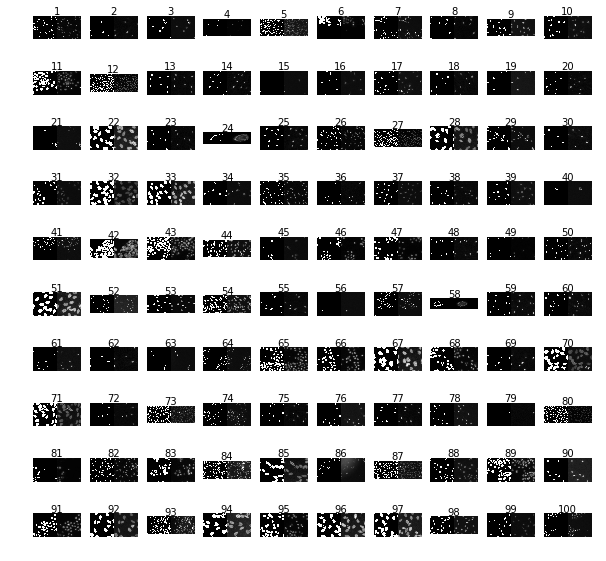

In [4]:
#首先展示原训练图片
batchDraw(before_train1_path, 100)

In [5]:
#slidingwindow
#滑窗法，用以数据增强，每隔64滑出一个256*256的图像
def slidingWindow(path):
    image_arr = []
    mask_arr = []
    bsize = 256
    interval = 64
    for (root, dirs, files) in os.walk(path):
        for j, Ufile in enumerate(files):
            img_path = os.path.join(root, Ufile)
            image_data = np.array(imread(img_path)).astype('float32')#float64精度过高，易导致OOM
            (h, w) = image_data.shape
            a = int(w / 2)            
            xx = int(np.floor(h - (bsize - interval)) / interval)
            yy = int(np.floor(a - (bsize - interval)) / interval)
            for i in range(1, (xx + 1)):
                for j in range(1, (yy + 1)):
                    left1 = (j - 1) * interval
                    right1 = (j - 1) * interval + bsize
                    left2 = a + (j - 1) * interval
                    right2 = a + (j - 1) * interval + bsize
                    down = (i - 1) * interval
                    up = (i - 1) * interval + bsize                    
                    mask = image_data[down:up, left1:right1]
                    img = image_data[down:up, left2:right2]                    
                    if np.sum(mask) > 256 * 256 * 15 and np.sum(img) > 256 * 256 * 15:
                        mask = mask / 255
                        mask_arr.append(mask)                   
                        img = img / 255
                        image_arr.append(img)
        image_arr = np.array(image_arr)
        mask_arr = np.array(mask_arr)        
    return image_arr, mask_arr

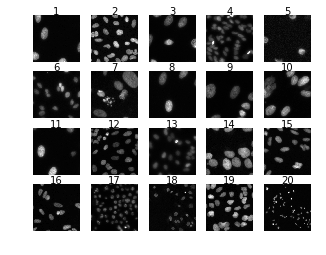

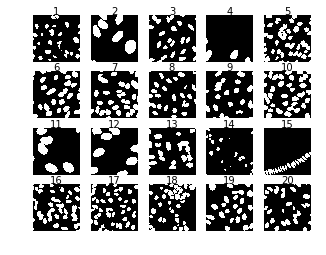

In [6]:
##展示滑窗后图片
batchDraw(train_image_path, 20)
batchDraw(train_mask_path, 20)

In [7]:
#由于test数据都是256*256，直接归一化即可
#归一化0-1的数据对应float32,0-255的数据对应unit8
def test_prepro(path):
    image_arr = []
    for(root, dirs, files) in os.walk(path):
        print("---")
        for j, Ufile in enumerate(files):
            img_path = os.path.join(root, Ufile)
            image = np.array(imread(img_path)).astype( 'float32' )
            image = image / 255
            image = image.reshape(image.shape[0], image.shape[1], 1)
            image_arr.append(image)
        image_arr = np.array(image_arr)
    return image_arr


In [8]:
##从滑动处理好的图片中抽取batchsize,边抽边读，不能从numpy数组中抽取（内存不够）
def gen_traindata(img_path, mask_path, batch_size):
    path_img = glob(img_path + '/*')
    path_mask = glob(mask_path + '/*')
    batch_num = int(np.floor(len(path_img) / batch_size))
    imsize = (batch_size, 256, 256, 1)
    for i in range(batch_num):#range(batch_num）还是range（batch_num - 1)
        image_train = []
        mask_train = []
        batch_img = path_img[i * batch_size : (i + 1) * batch_size]
        batch_mask = path_mask[i * batch_size : (i + 1) * batch_size]
        for img in batch_img:
            img = imread(img)
            h, w = img.shape
            img = img.reshape(img.shape + (1, ))
            image_train.append(img)
        image_train = np.array(image_train)
        for mask in batch_mask:
            mask = imread(mask)
            mask = mask.reshape(img.shape + (1, ))
            mask_train.append(mask)
        mask_train = np.array(mask_train).reshape(imsize)
        yield image_train, mask_train


In [9]:
#三种保存图像的方法
def saveResult1(save_path, image_arr):
    for i, item in enumerate(image_arr):
        size = item.shape
        item = item
        io.imsave(os.path.join(save_path, "%d.tif"%i), item)
        

def saveResult2(save_path, image_arr):
    image_arr = image_arr * 255
    image_arr = image_arr.astype('uint8')
    for i, item in enumerate(image_arr):
        io.imsave(os.path.join(save_path, "%d.tif"%i), item)
        
def saveResult3(save_path, image_arr):
    for i, item in enumerate(image_arr):
        item = (item - np.min(item)) / np.max(item)
        io.imsave(os.path.join(save_path, "%d.tif"%i), item)

In [10]:
#展示loss曲线的函数
def draw_loss(x, y, path):
    plt.plot(x, y, c = 'g')
    plt.savefig(path, dpi = 100)
    plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

[epoch 0/100] [batch 1/210] [loss:0.695235]
[epoch 0/100] [batch 2/210] [loss:0.692940]
[epoch 0/100] [batch 3/210] [loss:0.692910]
[epoch 0/100] [batch 4/210] [loss:0.692676]
[epoch 0/100] [batch 5/210] [loss:0.688377]
[epoch 0/100] [batch 6/210] [loss:0.686564]
[epoch 0/100] [batch 7/210] [loss:0.709293]
[epoch 0/100] [batch 8/210] [loss:0.682913]
[epoch 0/100] [batch 9/210] [loss:0.686940]
[epoch 0/100] [batch 10/210] [loss:0.684009]
[epoch 0/100] [batch 11/210] [loss:0.680238]
[epoch 0/100] [batch 12/210] [loss:0.671809]
[epoch 0/100] [batch 13/210] [loss:0.669006]
[epoch 0/100] [batch 14/210] [loss:0.661073]
[epoch 0/100] [batch 15/210] [loss:0.680512]
[epoch 0/100] [batch 16/210] [loss:0.687044]
[epoch 0/100] [batch 17/210] [loss:0.681035]
[epoch 0/100] [batch 18/210] [loss:0.689110]
[epoch 0/100] [batch 19/210] [loss:0.691189]
[epoch 0/100] [batch 20/210] [loss:0.688217]
[epoch 0/100] [batch 21/210] [loss:0.684132]
[epoch 0/100] [batch 22/210] [loss:0.673168]
[epoch 0/100] [batc

[epoch 0/100] [batch 182/210] [loss:0.568208]
[epoch 0/100] [batch 183/210] [loss:0.566872]
[epoch 0/100] [batch 184/210] [loss:0.592609]
[epoch 0/100] [batch 185/210] [loss:0.619618]
[epoch 0/100] [batch 186/210] [loss:0.611433]
[epoch 0/100] [batch 187/210] [loss:0.600316]
[epoch 0/100] [batch 188/210] [loss:0.582563]
[epoch 0/100] [batch 189/210] [loss:0.564582]
[epoch 0/100] [batch 190/210] [loss:0.538769]
[epoch 0/100] [batch 191/210] [loss:0.539282]
[epoch 0/100] [batch 192/210] [loss:0.557501]
[epoch 0/100] [batch 193/210] [loss:0.599481]
[epoch 0/100] [batch 194/210] [loss:0.622032]
[epoch 0/100] [batch 195/210] [loss:0.582874]
[epoch 0/100] [batch 196/210] [loss:0.540881]
[epoch 0/100] [batch 197/210] [loss:0.536047]
[epoch 0/100] [batch 198/210] [loss:0.595541]
[epoch 0/100] [batch 199/210] [loss:0.592540]
[epoch 0/100] [batch 200/210] [loss:0.569452]
[epoch 0/100] [batch 201/210] [loss:0.551617]
[epoch 0/100] [batch 202/210] [loss:0.554016]
[epoch 0/100] [batch 203/210] [los

[epoch 1/100] [batch 153/210] [loss:0.679246]
[epoch 1/100] [batch 154/210] [loss:0.679399]
[epoch 1/100] [batch 155/210] [loss:0.679536]
[epoch 1/100] [batch 156/210] [loss:0.679169]
[epoch 1/100] [batch 157/210] [loss:0.681966]
[epoch 1/100] [batch 158/210] [loss:0.684538]
[epoch 1/100] [batch 159/210] [loss:0.684094]
[epoch 1/100] [batch 160/210] [loss:0.685311]
[epoch 1/100] [batch 161/210] [loss:0.685911]
[epoch 1/100] [batch 162/210] [loss:0.684610]
[epoch 1/100] [batch 163/210] [loss:0.685342]
[epoch 1/100] [batch 164/210] [loss:0.686553]
[epoch 1/100] [batch 165/210] [loss:0.679859]
[epoch 1/100] [batch 166/210] [loss:0.686980]
[epoch 1/100] [batch 167/210] [loss:0.687719]
[epoch 1/100] [batch 168/210] [loss:0.684628]
[epoch 1/100] [batch 169/210] [loss:0.683388]
[epoch 1/100] [batch 170/210] [loss:0.681309]
[epoch 1/100] [batch 171/210] [loss:0.679146]
[epoch 1/100] [batch 172/210] [loss:0.684584]
[epoch 1/100] [batch 173/210] [loss:0.681194]
[epoch 1/100] [batch 174/210] [los

[epoch 2/100] [batch 124/210] [loss:0.677986]
[epoch 2/100] [batch 125/210] [loss:0.679028]
[epoch 2/100] [batch 126/210] [loss:0.678531]
[epoch 2/100] [batch 127/210] [loss:0.673321]
[epoch 2/100] [batch 128/210] [loss:0.674376]
[epoch 2/100] [batch 129/210] [loss:0.677233]
[epoch 2/100] [batch 130/210] [loss:0.678301]
[epoch 2/100] [batch 131/210] [loss:0.678371]
[epoch 2/100] [batch 132/210] [loss:0.677442]
[epoch 2/100] [batch 133/210] [loss:0.678053]
[epoch 2/100] [batch 134/210] [loss:0.677874]
[epoch 2/100] [batch 135/210] [loss:0.678103]
[epoch 2/100] [batch 136/210] [loss:0.676556]
[epoch 2/100] [batch 137/210] [loss:0.674528]
[epoch 2/100] [batch 138/210] [loss:0.674142]
[epoch 2/100] [batch 139/210] [loss:0.677531]
[epoch 2/100] [batch 140/210] [loss:0.670259]
[epoch 2/100] [batch 141/210] [loss:0.670649]
[epoch 2/100] [batch 142/210] [loss:0.669287]
[epoch 2/100] [batch 143/210] [loss:0.365432]
[epoch 2/100] [batch 144/210] [loss:1.825349]
[epoch 2/100] [batch 145/210] [los

[epoch 3/100] [batch 95/210] [loss:0.086637]
[epoch 3/100] [batch 96/210] [loss:0.168067]
[epoch 3/100] [batch 97/210] [loss:0.202608]
[epoch 3/100] [batch 98/210] [loss:0.110236]
[epoch 3/100] [batch 99/210] [loss:0.086515]
[epoch 3/100] [batch 100/210] [loss:0.144112]
[epoch 3/100] [batch 101/210] [loss:0.143273]
[epoch 3/100] [batch 102/210] [loss:0.075978]
[epoch 3/100] [batch 103/210] [loss:0.050554]
[epoch 3/100] [batch 104/210] [loss:0.039479]
[epoch 3/100] [batch 105/210] [loss:0.059905]
[epoch 3/100] [batch 106/210] [loss:0.081020]
[epoch 3/100] [batch 107/210] [loss:0.102000]
[epoch 3/100] [batch 108/210] [loss:0.062027]
[epoch 3/100] [batch 109/210] [loss:0.053338]
[epoch 3/100] [batch 110/210] [loss:0.055997]
[epoch 3/100] [batch 111/210] [loss:0.062478]
[epoch 3/100] [batch 112/210] [loss:0.058727]
[epoch 3/100] [batch 113/210] [loss:0.089085]
[epoch 3/100] [batch 114/210] [loss:0.136071]
[epoch 3/100] [batch 115/210] [loss:0.095759]
[epoch 3/100] [batch 116/210] [loss:0.0

[epoch 4/100] [batch 65/210] [loss:0.057103]
[epoch 4/100] [batch 66/210] [loss:0.051173]
[epoch 4/100] [batch 67/210] [loss:0.063760]
[epoch 4/100] [batch 68/210] [loss:0.073307]
[epoch 4/100] [batch 69/210] [loss:0.059497]
[epoch 4/100] [batch 70/210] [loss:0.066581]
[epoch 4/100] [batch 71/210] [loss:0.063109]
[epoch 4/100] [batch 72/210] [loss:0.074331]
[epoch 4/100] [batch 73/210] [loss:0.110001]
[epoch 4/100] [batch 74/210] [loss:0.136679]
[epoch 4/100] [batch 75/210] [loss:0.124188]
[epoch 4/100] [batch 76/210] [loss:0.110580]
[epoch 4/100] [batch 77/210] [loss:0.082173]
[epoch 4/100] [batch 78/210] [loss:0.049409]
[epoch 4/100] [batch 79/210] [loss:0.049672]
[epoch 4/100] [batch 80/210] [loss:0.069572]
[epoch 4/100] [batch 81/210] [loss:0.079690]
[epoch 4/100] [batch 82/210] [loss:0.119748]
[epoch 4/100] [batch 83/210] [loss:0.130741]
[epoch 4/100] [batch 84/210] [loss:0.138024]
[epoch 4/100] [batch 85/210] [loss:0.073603]
[epoch 4/100] [batch 86/210] [loss:0.031852]
[epoch 4/1

[epoch 5/100] [batch 35/210] [loss:0.054908]
[epoch 5/100] [batch 36/210] [loss:0.061528]
[epoch 5/100] [batch 37/210] [loss:0.038890]
[epoch 5/100] [batch 38/210] [loss:0.033271]
[epoch 5/100] [batch 39/210] [loss:0.124409]
[epoch 5/100] [batch 40/210] [loss:0.120553]
[epoch 5/100] [batch 41/210] [loss:0.122317]
[epoch 5/100] [batch 42/210] [loss:0.086241]
[epoch 5/100] [batch 43/210] [loss:0.020948]
[epoch 5/100] [batch 44/210] [loss:0.024828]
[epoch 5/100] [batch 45/210] [loss:0.019451]
[epoch 5/100] [batch 46/210] [loss:0.017401]
[epoch 5/100] [batch 47/210] [loss:0.013878]
[epoch 5/100] [batch 48/210] [loss:0.011518]
[epoch 5/100] [batch 49/210] [loss:0.017757]
[epoch 5/100] [batch 50/210] [loss:0.012671]
[epoch 5/100] [batch 51/210] [loss:0.052167]
[epoch 5/100] [batch 52/210] [loss:0.100917]
[epoch 5/100] [batch 53/210] [loss:0.120695]
[epoch 5/100] [batch 54/210] [loss:0.070070]
[epoch 5/100] [batch 55/210] [loss:0.043464]
[epoch 5/100] [batch 56/210] [loss:0.054733]
[epoch 5/1

[epoch 6/100] [batch 5/210] [loss:0.030503]
[epoch 6/100] [batch 6/210] [loss:0.066659]
[epoch 6/100] [batch 7/210] [loss:0.093154]
[epoch 6/100] [batch 8/210] [loss:0.067359]
[epoch 6/100] [batch 9/210] [loss:0.087411]
[epoch 6/100] [batch 10/210] [loss:0.093529]
[epoch 6/100] [batch 11/210] [loss:0.106950]
[epoch 6/100] [batch 12/210] [loss:0.046998]
[epoch 6/100] [batch 13/210] [loss:0.059320]
[epoch 6/100] [batch 14/210] [loss:0.068445]
[epoch 6/100] [batch 15/210] [loss:0.051051]
[epoch 6/100] [batch 16/210] [loss:0.042717]
[epoch 6/100] [batch 17/210] [loss:0.042941]
[epoch 6/100] [batch 18/210] [loss:0.076343]
[epoch 6/100] [batch 19/210] [loss:0.253755]
[epoch 6/100] [batch 20/210] [loss:0.022937]
[epoch 6/100] [batch 21/210] [loss:0.026280]
[epoch 6/100] [batch 22/210] [loss:0.026429]
[epoch 6/100] [batch 23/210] [loss:0.104549]
[epoch 6/100] [batch 24/210] [loss:0.038927]
[epoch 6/100] [batch 25/210] [loss:0.032034]
[epoch 6/100] [batch 26/210] [loss:0.040547]
[epoch 6/100] [

[epoch 6/100] [batch 186/210] [loss:0.082100]
[epoch 6/100] [batch 187/210] [loss:0.054468]
[epoch 6/100] [batch 188/210] [loss:0.029661]
[epoch 6/100] [batch 189/210] [loss:0.029866]
[epoch 6/100] [batch 190/210] [loss:0.074991]
[epoch 6/100] [batch 191/210] [loss:0.091780]
[epoch 6/100] [batch 192/210] [loss:0.088259]
[epoch 6/100] [batch 193/210] [loss:0.073312]
[epoch 6/100] [batch 194/210] [loss:0.070513]
[epoch 6/100] [batch 195/210] [loss:0.086109]
[epoch 6/100] [batch 196/210] [loss:0.049041]
[epoch 6/100] [batch 197/210] [loss:0.044581]
[epoch 6/100] [batch 198/210] [loss:0.070927]
[epoch 6/100] [batch 199/210] [loss:0.072200]
[epoch 6/100] [batch 200/210] [loss:0.064414]
[epoch 6/100] [batch 201/210] [loss:0.049846]
[epoch 6/100] [batch 202/210] [loss:0.048667]
[epoch 6/100] [batch 203/210] [loss:0.071575]
[epoch 6/100] [batch 204/210] [loss:0.036004]
[epoch 6/100] [batch 205/210] [loss:0.014649]
[epoch 6/100] [batch 206/210] [loss:0.059650]
[epoch 6/100] [batch 207/210] [los

[epoch 7/100] [batch 157/210] [loss:0.060021]
[epoch 7/100] [batch 158/210] [loss:0.064647]
[epoch 7/100] [batch 159/210] [loss:0.062847]
[epoch 7/100] [batch 160/210] [loss:0.099206]
[epoch 7/100] [batch 161/210] [loss:0.110970]
[epoch 7/100] [batch 162/210] [loss:0.087887]
[epoch 7/100] [batch 163/210] [loss:0.126487]
[epoch 7/100] [batch 164/210] [loss:0.139224]
[epoch 7/100] [batch 165/210] [loss:0.027916]
[epoch 7/100] [batch 166/210] [loss:0.066043]
[epoch 7/100] [batch 167/210] [loss:0.076887]
[epoch 7/100] [batch 168/210] [loss:0.053012]
[epoch 7/100] [batch 169/210] [loss:0.042690]
[epoch 7/100] [batch 170/210] [loss:0.084268]
[epoch 7/100] [batch 171/210] [loss:0.101172]
[epoch 7/100] [batch 172/210] [loss:0.061427]
[epoch 7/100] [batch 173/210] [loss:0.020455]
[epoch 7/100] [batch 174/210] [loss:0.007348]
[epoch 7/100] [batch 175/210] [loss:0.026617]
[epoch 7/100] [batch 176/210] [loss:0.056622]
[epoch 7/100] [batch 177/210] [loss:0.033176]
[epoch 7/100] [batch 178/210] [los

[epoch 8/100] [batch 128/210] [loss:0.013089]
[epoch 8/100] [batch 129/210] [loss:0.030420]
[epoch 8/100] [batch 130/210] [loss:0.034091]
[epoch 8/100] [batch 131/210] [loss:0.024060]
[epoch 8/100] [batch 132/210] [loss:0.019943]
[epoch 8/100] [batch 133/210] [loss:0.024821]
[epoch 8/100] [batch 134/210] [loss:0.030367]
[epoch 8/100] [batch 135/210] [loss:0.034477]
[epoch 8/100] [batch 136/210] [loss:0.031715]
[epoch 8/100] [batch 137/210] [loss:0.023295]
[epoch 8/100] [batch 138/210] [loss:0.025128]
[epoch 8/100] [batch 139/210] [loss:0.029540]
[epoch 8/100] [batch 140/210] [loss:0.018701]
[epoch 8/100] [batch 141/210] [loss:0.015907]
[epoch 8/100] [batch 142/210] [loss:0.029949]
[epoch 8/100] [batch 143/210] [loss:0.032293]
[epoch 8/100] [batch 144/210] [loss:0.068641]
[epoch 8/100] [batch 145/210] [loss:0.083389]
[epoch 8/100] [batch 146/210] [loss:0.059941]
[epoch 8/100] [batch 147/210] [loss:0.019740]
[epoch 8/100] [batch 148/210] [loss:0.020569]
[epoch 8/100] [batch 149/210] [los

[epoch 9/100] [batch 99/210] [loss:0.035460]
[epoch 9/100] [batch 100/210] [loss:0.045458]
[epoch 9/100] [batch 101/210] [loss:0.045592]
[epoch 9/100] [batch 102/210] [loss:0.038513]
[epoch 9/100] [batch 103/210] [loss:0.017243]
[epoch 9/100] [batch 104/210] [loss:0.016183]
[epoch 9/100] [batch 105/210] [loss:0.021062]
[epoch 9/100] [batch 106/210] [loss:0.039442]
[epoch 9/100] [batch 107/210] [loss:0.048067]
[epoch 9/100] [batch 108/210] [loss:0.038703]
[epoch 9/100] [batch 109/210] [loss:0.033204]
[epoch 9/100] [batch 110/210] [loss:0.037299]
[epoch 9/100] [batch 111/210] [loss:0.034402]
[epoch 9/100] [batch 112/210] [loss:0.033160]
[epoch 9/100] [batch 113/210] [loss:0.034469]
[epoch 9/100] [batch 114/210] [loss:0.041025]
[epoch 9/100] [batch 115/210] [loss:0.052800]
[epoch 9/100] [batch 116/210] [loss:0.044349]
[epoch 9/100] [batch 117/210] [loss:0.040139]
[epoch 9/100] [batch 118/210] [loss:0.060555]
[epoch 9/100] [batch 119/210] [loss:0.091059]
[epoch 9/100] [batch 120/210] [loss

[epoch 10/100] [batch 68/210] [loss:0.051222]
[epoch 10/100] [batch 69/210] [loss:0.038254]
[epoch 10/100] [batch 70/210] [loss:0.047593]
[epoch 10/100] [batch 71/210] [loss:0.036374]
[epoch 10/100] [batch 72/210] [loss:0.038965]
[epoch 10/100] [batch 73/210] [loss:0.055300]
[epoch 10/100] [batch 74/210] [loss:0.071842]
[epoch 10/100] [batch 75/210] [loss:0.087017]
[epoch 10/100] [batch 76/210] [loss:0.075561]
[epoch 10/100] [batch 77/210] [loss:0.059839]
[epoch 10/100] [batch 78/210] [loss:0.040231]
[epoch 10/100] [batch 79/210] [loss:0.041746]
[epoch 10/100] [batch 80/210] [loss:0.042652]
[epoch 10/100] [batch 81/210] [loss:0.040183]
[epoch 10/100] [batch 82/210] [loss:0.079730]
[epoch 10/100] [batch 83/210] [loss:0.089199]
[epoch 10/100] [batch 84/210] [loss:0.096372]
[epoch 10/100] [batch 85/210] [loss:0.052040]
[epoch 10/100] [batch 86/210] [loss:0.018843]
[epoch 10/100] [batch 87/210] [loss:0.041747]
[epoch 10/100] [batch 88/210] [loss:0.059759]
[epoch 10/100] [batch 89/210] [los

[epoch 11/100] [batch 34/210] [loss:0.023741]
[epoch 11/100] [batch 35/210] [loss:0.041289]
[epoch 11/100] [batch 36/210] [loss:0.055254]
[epoch 11/100] [batch 37/210] [loss:0.031268]
[epoch 11/100] [batch 38/210] [loss:0.027963]
[epoch 11/100] [batch 39/210] [loss:0.120829]
[epoch 11/100] [batch 40/210] [loss:0.120657]
[epoch 11/100] [batch 41/210] [loss:0.118108]
[epoch 11/100] [batch 42/210] [loss:0.073940]
[epoch 11/100] [batch 43/210] [loss:0.015314]
[epoch 11/100] [batch 44/210] [loss:0.015177]
[epoch 11/100] [batch 45/210] [loss:0.012435]
[epoch 11/100] [batch 46/210] [loss:0.012864]
[epoch 11/100] [batch 47/210] [loss:0.010402]
[epoch 11/100] [batch 48/210] [loss:0.009631]
[epoch 11/100] [batch 49/210] [loss:0.014920]
[epoch 11/100] [batch 50/210] [loss:0.011112]
[epoch 11/100] [batch 51/210] [loss:0.041239]
[epoch 11/100] [batch 52/210] [loss:0.096706]
[epoch 11/100] [batch 53/210] [loss:0.111840]
[epoch 11/100] [batch 54/210] [loss:0.065079]
[epoch 11/100] [batch 55/210] [los

[epoch 11/100] [batch 210/210] [loss:0.087927]
[epoch 12/100] [batch 1/210] [loss:0.098864]
[epoch 12/100] [batch 2/210] [loss:0.140321]
[epoch 12/100] [batch 3/210] [loss:0.083239]
[epoch 12/100] [batch 4/210] [loss:0.022048]
[epoch 12/100] [batch 5/210] [loss:0.024791]
[epoch 12/100] [batch 6/210] [loss:0.055852]
[epoch 12/100] [batch 7/210] [loss:0.061764]
[epoch 12/100] [batch 8/210] [loss:0.046638]
[epoch 12/100] [batch 9/210] [loss:0.070875]
[epoch 12/100] [batch 10/210] [loss:0.087583]
[epoch 12/100] [batch 11/210] [loss:0.102143]
[epoch 12/100] [batch 12/210] [loss:0.034035]
[epoch 12/100] [batch 13/210] [loss:0.038216]
[epoch 12/100] [batch 14/210] [loss:0.043189]
[epoch 12/100] [batch 15/210] [loss:0.038206]
[epoch 12/100] [batch 16/210] [loss:0.037254]
[epoch 12/100] [batch 17/210] [loss:0.037417]
[epoch 12/100] [batch 18/210] [loss:0.069516]
[epoch 12/100] [batch 19/210] [loss:0.211279]
[epoch 12/100] [batch 20/210] [loss:0.019447]
[epoch 12/100] [batch 21/210] [loss:0.0200

[epoch 12/100] [batch 177/210] [loss:0.031101]
[epoch 12/100] [batch 178/210] [loss:0.035448]
[epoch 12/100] [batch 179/210] [loss:0.025805]
[epoch 12/100] [batch 180/210] [loss:0.015075]
[epoch 12/100] [batch 181/210] [loss:0.055887]
[epoch 12/100] [batch 182/210] [loss:0.038136]
[epoch 12/100] [batch 183/210] [loss:0.023116]
[epoch 12/100] [batch 184/210] [loss:0.025524]
[epoch 12/100] [batch 185/210] [loss:0.082205]
[epoch 12/100] [batch 186/210] [loss:0.087065]
[epoch 12/100] [batch 187/210] [loss:0.054068]
[epoch 12/100] [batch 188/210] [loss:0.026418]
[epoch 12/100] [batch 189/210] [loss:0.027115]
[epoch 12/100] [batch 190/210] [loss:0.067873]
[epoch 12/100] [batch 191/210] [loss:0.080521]
[epoch 12/100] [batch 192/210] [loss:0.076538]
[epoch 12/100] [batch 193/210] [loss:0.058389]
[epoch 12/100] [batch 194/210] [loss:0.056065]
[epoch 12/100] [batch 195/210] [loss:0.072476]
[epoch 12/100] [batch 196/210] [loss:0.044686]
[epoch 12/100] [batch 197/210] [loss:0.041192]
[epoch 12/100

[epoch 13/100] [batch 144/210] [loss:0.061646]
[epoch 13/100] [batch 145/210] [loss:0.071696]
[epoch 13/100] [batch 146/210] [loss:0.052515]
[epoch 13/100] [batch 147/210] [loss:0.019608]
[epoch 13/100] [batch 148/210] [loss:0.019745]
[epoch 13/100] [batch 149/210] [loss:0.026042]
[epoch 13/100] [batch 150/210] [loss:0.023943]
[epoch 13/100] [batch 151/210] [loss:0.024162]
[epoch 13/100] [batch 152/210] [loss:0.037065]
[epoch 13/100] [batch 153/210] [loss:0.045089]
[epoch 13/100] [batch 154/210] [loss:0.053162]
[epoch 13/100] [batch 155/210] [loss:0.062337]
[epoch 13/100] [batch 156/210] [loss:0.050534]
[epoch 13/100] [batch 157/210] [loss:0.053775]
[epoch 13/100] [batch 158/210] [loss:0.060377]
[epoch 13/100] [batch 159/210] [loss:0.057684]
[epoch 13/100] [batch 160/210] [loss:0.087366]
[epoch 13/100] [batch 161/210] [loss:0.097087]
[epoch 13/100] [batch 162/210] [loss:0.080971]
[epoch 13/100] [batch 163/210] [loss:0.121813]
[epoch 13/100] [batch 164/210] [loss:0.134086]
[epoch 13/100

[epoch 14/100] [batch 111/210] [loss:0.034833]
[epoch 14/100] [batch 112/210] [loss:0.032787]
[epoch 14/100] [batch 113/210] [loss:0.032692]
[epoch 14/100] [batch 114/210] [loss:0.037271]
[epoch 14/100] [batch 115/210] [loss:0.050965]
[epoch 14/100] [batch 116/210] [loss:0.042686]
[epoch 14/100] [batch 117/210] [loss:0.038788]
[epoch 14/100] [batch 118/210] [loss:0.062773]
[epoch 14/100] [batch 119/210] [loss:0.099892]
[epoch 14/100] [batch 120/210] [loss:0.097577]
[epoch 14/100] [batch 121/210] [loss:0.067256]
[epoch 14/100] [batch 122/210] [loss:0.059404]
[epoch 14/100] [batch 123/210] [loss:0.057951]
[epoch 14/100] [batch 124/210] [loss:0.065252]
[epoch 14/100] [batch 125/210] [loss:0.042686]
[epoch 14/100] [batch 126/210] [loss:0.035528]
[epoch 14/100] [batch 127/210] [loss:0.010089]
[epoch 14/100] [batch 128/210] [loss:0.013542]
[epoch 14/100] [batch 129/210] [loss:0.030585]
[epoch 14/100] [batch 130/210] [loss:0.032789]
[epoch 14/100] [batch 131/210] [loss:0.025663]
[epoch 14/100

[epoch 15/100] [batch 78/210] [loss:0.039142]
[epoch 15/100] [batch 79/210] [loss:0.040312]
[epoch 15/100] [batch 80/210] [loss:0.042960]
[epoch 15/100] [batch 81/210] [loss:0.041363]
[epoch 15/100] [batch 82/210] [loss:0.077978]
[epoch 15/100] [batch 83/210] [loss:0.085183]
[epoch 15/100] [batch 84/210] [loss:0.089556]
[epoch 15/100] [batch 85/210] [loss:0.050351]
[epoch 15/100] [batch 86/210] [loss:0.021112]
[epoch 15/100] [batch 87/210] [loss:0.041559]
[epoch 15/100] [batch 88/210] [loss:0.058208]
[epoch 15/100] [batch 89/210] [loss:0.056385]
[epoch 15/100] [batch 90/210] [loss:0.068294]
[epoch 15/100] [batch 91/210] [loss:0.077879]
[epoch 15/100] [batch 92/210] [loss:0.052350]
[epoch 15/100] [batch 93/210] [loss:0.095364]
[epoch 15/100] [batch 94/210] [loss:0.029804]
[epoch 15/100] [batch 95/210] [loss:0.028987]
[epoch 15/100] [batch 96/210] [loss:0.088173]
[epoch 15/100] [batch 97/210] [loss:0.099606]
[epoch 15/100] [batch 98/210] [loss:0.066619]
[epoch 15/100] [batch 99/210] [los

[epoch 16/100] [batch 44/210] [loss:0.018720]
[epoch 16/100] [batch 45/210] [loss:0.014844]
[epoch 16/100] [batch 46/210] [loss:0.014427]
[epoch 16/100] [batch 47/210] [loss:0.012351]
[epoch 16/100] [batch 48/210] [loss:0.010754]
[epoch 16/100] [batch 49/210] [loss:0.015968]
[epoch 16/100] [batch 50/210] [loss:0.011021]
[epoch 16/100] [batch 51/210] [loss:0.045643]
[epoch 16/100] [batch 52/210] [loss:0.111288]
[epoch 16/100] [batch 53/210] [loss:0.135058]
[epoch 16/100] [batch 54/210] [loss:0.075111]
[epoch 16/100] [batch 55/210] [loss:0.035184]
[epoch 16/100] [batch 56/210] [loss:0.047759]
[epoch 16/100] [batch 57/210] [loss:0.044804]
[epoch 16/100] [batch 58/210] [loss:0.071265]
[epoch 16/100] [batch 59/210] [loss:0.093797]
[epoch 16/100] [batch 60/210] [loss:0.070696]
[epoch 16/100] [batch 61/210] [loss:0.045129]
[epoch 16/100] [batch 62/210] [loss:0.032224]
[epoch 16/100] [batch 63/210] [loss:0.046600]
[epoch 16/100] [batch 64/210] [loss:0.043218]
[epoch 16/100] [batch 65/210] [los

[epoch 17/100] [batch 10/210] [loss:0.088893]
[epoch 17/100] [batch 11/210] [loss:0.104172]
[epoch 17/100] [batch 12/210] [loss:0.037149]
[epoch 17/100] [batch 13/210] [loss:0.043611]
[epoch 17/100] [batch 14/210] [loss:0.048773]
[epoch 17/100] [batch 15/210] [loss:0.039212]
[epoch 17/100] [batch 16/210] [loss:0.034608]
[epoch 17/100] [batch 17/210] [loss:0.034303]
[epoch 17/100] [batch 18/210] [loss:0.066387]
[epoch 17/100] [batch 19/210] [loss:0.202513]
[epoch 17/100] [batch 20/210] [loss:0.017984]
[epoch 17/100] [batch 21/210] [loss:0.019051]
[epoch 17/100] [batch 22/210] [loss:0.020272]
[epoch 17/100] [batch 23/210] [loss:0.085809]
[epoch 17/100] [batch 24/210] [loss:0.037674]
[epoch 17/100] [batch 25/210] [loss:0.033780]
[epoch 17/100] [batch 26/210] [loss:0.041199]
[epoch 17/100] [batch 27/210] [loss:0.055224]
[epoch 17/100] [batch 28/210] [loss:0.085265]
[epoch 17/100] [batch 29/210] [loss:0.057893]
[epoch 17/100] [batch 30/210] [loss:0.147288]
[epoch 17/100] [batch 31/210] [los

[epoch 17/100] [batch 187/210] [loss:0.054961]
[epoch 17/100] [batch 188/210] [loss:0.025195]
[epoch 17/100] [batch 189/210] [loss:0.025985]
[epoch 17/100] [batch 190/210] [loss:0.064555]
[epoch 17/100] [batch 191/210] [loss:0.078413]
[epoch 17/100] [batch 192/210] [loss:0.076145]
[epoch 17/100] [batch 193/210] [loss:0.058167]
[epoch 17/100] [batch 194/210] [loss:0.055089]
[epoch 17/100] [batch 195/210] [loss:0.075527]
[epoch 17/100] [batch 196/210] [loss:0.042972]
[epoch 17/100] [batch 197/210] [loss:0.039443]
[epoch 17/100] [batch 198/210] [loss:0.061545]
[epoch 17/100] [batch 199/210] [loss:0.062251]
[epoch 17/100] [batch 200/210] [loss:0.057398]
[epoch 17/100] [batch 201/210] [loss:0.044451]
[epoch 17/100] [batch 202/210] [loss:0.042345]
[epoch 17/100] [batch 203/210] [loss:0.064263]
[epoch 17/100] [batch 204/210] [loss:0.033165]
[epoch 17/100] [batch 205/210] [loss:0.013039]
[epoch 17/100] [batch 206/210] [loss:0.046554]
[epoch 17/100] [batch 207/210] [loss:0.078102]
[epoch 17/100

[epoch 18/100] [batch 154/210] [loss:0.051452]
[epoch 18/100] [batch 155/210] [loss:0.060415]
[epoch 18/100] [batch 156/210] [loss:0.049287]
[epoch 18/100] [batch 157/210] [loss:0.054813]
[epoch 18/100] [batch 158/210] [loss:0.062174]
[epoch 18/100] [batch 159/210] [loss:0.057786]
[epoch 18/100] [batch 160/210] [loss:0.085539]
[epoch 18/100] [batch 161/210] [loss:0.095799]
[epoch 18/100] [batch 162/210] [loss:0.080022]
[epoch 18/100] [batch 163/210] [loss:0.120453]
[epoch 18/100] [batch 164/210] [loss:0.131542]
[epoch 18/100] [batch 165/210] [loss:0.024985]
[epoch 18/100] [batch 166/210] [loss:0.056838]
[epoch 18/100] [batch 167/210] [loss:0.064413]
[epoch 18/100] [batch 168/210] [loss:0.042911]
[epoch 18/100] [batch 169/210] [loss:0.034298]
[epoch 18/100] [batch 170/210] [loss:0.045794]
[epoch 18/100] [batch 171/210] [loss:0.044809]
[epoch 18/100] [batch 172/210] [loss:0.055012]
[epoch 18/100] [batch 173/210] [loss:0.018919]
[epoch 18/100] [batch 174/210] [loss:0.006617]
[epoch 18/100

[epoch 19/100] [batch 121/210] [loss:0.058457]
[epoch 19/100] [batch 122/210] [loss:0.057146]
[epoch 19/100] [batch 123/210] [loss:0.051076]
[epoch 19/100] [batch 124/210] [loss:0.065028]
[epoch 19/100] [batch 125/210] [loss:0.041153]
[epoch 19/100] [batch 126/210] [loss:0.034939]
[epoch 19/100] [batch 127/210] [loss:0.009494]
[epoch 19/100] [batch 128/210] [loss:0.012637]
[epoch 19/100] [batch 129/210] [loss:0.028946]
[epoch 19/100] [batch 130/210] [loss:0.029677]
[epoch 19/100] [batch 131/210] [loss:0.024643]
[epoch 19/100] [batch 132/210] [loss:0.019987]
[epoch 19/100] [batch 133/210] [loss:0.023616]
[epoch 19/100] [batch 134/210] [loss:0.030729]
[epoch 19/100] [batch 135/210] [loss:0.032890]
[epoch 19/100] [batch 136/210] [loss:0.030535]
[epoch 19/100] [batch 137/210] [loss:0.021692]
[epoch 19/100] [batch 138/210] [loss:0.023799]
[epoch 19/100] [batch 139/210] [loss:0.027880]
[epoch 19/100] [batch 140/210] [loss:0.017300]
[epoch 19/100] [batch 141/210] [loss:0.014966]
[epoch 19/100

[epoch 20/100] [batch 88/210] [loss:0.055520]
[epoch 20/100] [batch 89/210] [loss:0.054685]
[epoch 20/100] [batch 90/210] [loss:0.065773]
[epoch 20/100] [batch 91/210] [loss:0.071357]
[epoch 20/100] [batch 92/210] [loss:0.050937]
[epoch 20/100] [batch 93/210] [loss:0.092850]
[epoch 20/100] [batch 94/210] [loss:0.026838]
[epoch 20/100] [batch 95/210] [loss:0.026716]
[epoch 20/100] [batch 96/210] [loss:0.060529]
[epoch 20/100] [batch 97/210] [loss:0.078466]
[epoch 20/100] [batch 98/210] [loss:0.059056]
[epoch 20/100] [batch 99/210] [loss:0.033266]
[epoch 20/100] [batch 100/210] [loss:0.044274]
[epoch 20/100] [batch 101/210] [loss:0.043099]
[epoch 20/100] [batch 102/210] [loss:0.033786]
[epoch 20/100] [batch 103/210] [loss:0.016373]
[epoch 20/100] [batch 104/210] [loss:0.016186]
[epoch 20/100] [batch 105/210] [loss:0.019415]
[epoch 20/100] [batch 106/210] [loss:0.036999]
[epoch 20/100] [batch 107/210] [loss:0.045047]
[epoch 20/100] [batch 108/210] [loss:0.036812]
[epoch 20/100] [batch 109

[epoch 21/100] [batch 54/210] [loss:0.053785]
[epoch 21/100] [batch 55/210] [loss:0.034111]
[epoch 21/100] [batch 56/210] [loss:0.045971]
[epoch 21/100] [batch 57/210] [loss:0.041476]
[epoch 21/100] [batch 58/210] [loss:0.066048]
[epoch 21/100] [batch 59/210] [loss:0.085863]
[epoch 21/100] [batch 60/210] [loss:0.068315]
[epoch 21/100] [batch 61/210] [loss:0.045004]
[epoch 21/100] [batch 62/210] [loss:0.031087]
[epoch 21/100] [batch 63/210] [loss:0.044076]
[epoch 21/100] [batch 64/210] [loss:0.040937]
[epoch 21/100] [batch 65/210] [loss:0.028104]
[epoch 21/100] [batch 66/210] [loss:0.034609]
[epoch 21/100] [batch 67/210] [loss:0.041826]
[epoch 21/100] [batch 68/210] [loss:0.053355]
[epoch 21/100] [batch 69/210] [loss:0.038937]
[epoch 21/100] [batch 70/210] [loss:0.043727]
[epoch 21/100] [batch 71/210] [loss:0.031291]
[epoch 21/100] [batch 72/210] [loss:0.034172]
[epoch 21/100] [batch 73/210] [loss:0.028409]
[epoch 21/100] [batch 74/210] [loss:0.042879]
[epoch 21/100] [batch 75/210] [los

[epoch 22/100] [batch 20/210] [loss:0.017433]
[epoch 22/100] [batch 21/210] [loss:0.017997]
[epoch 22/100] [batch 22/210] [loss:0.018944]
[epoch 22/100] [batch 23/210] [loss:0.081797]
[epoch 22/100] [batch 24/210] [loss:0.035164]
[epoch 22/100] [batch 25/210] [loss:0.028568]
[epoch 22/100] [batch 26/210] [loss:0.036811]
[epoch 22/100] [batch 27/210] [loss:0.048575]
[epoch 22/100] [batch 28/210] [loss:0.074365]
[epoch 22/100] [batch 29/210] [loss:0.050413]
[epoch 22/100] [batch 30/210] [loss:0.143152]
[epoch 22/100] [batch 31/210] [loss:0.170455]
[epoch 22/100] [batch 32/210] [loss:0.144944]
[epoch 22/100] [batch 33/210] [loss:0.022358]
[epoch 22/100] [batch 34/210] [loss:0.022190]
[epoch 22/100] [batch 35/210] [loss:0.038946]
[epoch 22/100] [batch 36/210] [loss:0.051282]
[epoch 22/100] [batch 37/210] [loss:0.030373]
[epoch 22/100] [batch 38/210] [loss:0.027659]
[epoch 22/100] [batch 39/210] [loss:0.114295]
[epoch 22/100] [batch 40/210] [loss:0.127777]
[epoch 22/100] [batch 41/210] [los

[epoch 22/100] [batch 197/210] [loss:0.041288]
[epoch 22/100] [batch 198/210] [loss:0.061917]
[epoch 22/100] [batch 199/210] [loss:0.061257]
[epoch 22/100] [batch 200/210] [loss:0.055338]
[epoch 22/100] [batch 201/210] [loss:0.041590]
[epoch 22/100] [batch 202/210] [loss:0.040604]
[epoch 22/100] [batch 203/210] [loss:0.062794]
[epoch 22/100] [batch 204/210] [loss:0.031599]
[epoch 22/100] [batch 205/210] [loss:0.012634]
[epoch 22/100] [batch 206/210] [loss:0.044999]
[epoch 22/100] [batch 207/210] [loss:0.074107]
[epoch 22/100] [batch 208/210] [loss:0.104165]
[epoch 22/100] [batch 209/210] [loss:0.078513]
[epoch 22/100] [batch 210/210] [loss:0.082312]
[epoch 23/100] [batch 1/210] [loss:0.093326]
[epoch 23/100] [batch 2/210] [loss:0.134805]
[epoch 23/100] [batch 3/210] [loss:0.080644]
[epoch 23/100] [batch 4/210] [loss:0.021245]
[epoch 23/100] [batch 5/210] [loss:0.024029]
[epoch 23/100] [batch 6/210] [loss:0.052369]
[epoch 23/100] [batch 7/210] [loss:0.052372]
[epoch 23/100] [batch 8/210

[epoch 23/100] [batch 164/210] [loss:0.128155]
[epoch 23/100] [batch 165/210] [loss:0.026245]
[epoch 23/100] [batch 166/210] [loss:0.056558]
[epoch 23/100] [batch 167/210] [loss:0.064333]
[epoch 23/100] [batch 168/210] [loss:0.044157]
[epoch 23/100] [batch 169/210] [loss:0.035838]
[epoch 23/100] [batch 170/210] [loss:0.041081]
[epoch 23/100] [batch 171/210] [loss:0.034495]
[epoch 23/100] [batch 172/210] [loss:0.052567]
[epoch 23/100] [batch 173/210] [loss:0.018443]
[epoch 23/100] [batch 174/210] [loss:0.006447]
[epoch 23/100] [batch 175/210] [loss:0.025183]
[epoch 23/100] [batch 176/210] [loss:0.051639]
[epoch 23/100] [batch 177/210] [loss:0.030095]
[epoch 23/100] [batch 178/210] [loss:0.034341]
[epoch 23/100] [batch 179/210] [loss:0.023160]
[epoch 23/100] [batch 180/210] [loss:0.013758]
[epoch 23/100] [batch 181/210] [loss:0.057252]
[epoch 23/100] [batch 182/210] [loss:0.036417]
[epoch 23/100] [batch 183/210] [loss:0.021244]
[epoch 23/100] [batch 184/210] [loss:0.022961]
[epoch 23/100

[epoch 24/100] [batch 131/210] [loss:0.022363]
[epoch 24/100] [batch 132/210] [loss:0.019729]
[epoch 24/100] [batch 133/210] [loss:0.023196]
[epoch 24/100] [batch 134/210] [loss:0.029057]
[epoch 24/100] [batch 135/210] [loss:0.032386]
[epoch 24/100] [batch 136/210] [loss:0.030680]
[epoch 24/100] [batch 137/210] [loss:0.021763]
[epoch 24/100] [batch 138/210] [loss:0.024013]
[epoch 24/100] [batch 139/210] [loss:0.026824]
[epoch 24/100] [batch 140/210] [loss:0.016652]
[epoch 24/100] [batch 141/210] [loss:0.014465]
[epoch 24/100] [batch 142/210] [loss:0.027430]
[epoch 24/100] [batch 143/210] [loss:0.030001]
[epoch 24/100] [batch 144/210] [loss:0.059377]
[epoch 24/100] [batch 145/210] [loss:0.068824]
[epoch 24/100] [batch 146/210] [loss:0.050770]
[epoch 24/100] [batch 147/210] [loss:0.019963]
[epoch 24/100] [batch 148/210] [loss:0.019545]
[epoch 24/100] [batch 149/210] [loss:0.024529]
[epoch 24/100] [batch 150/210] [loss:0.021613]
[epoch 24/100] [batch 151/210] [loss:0.023438]
[epoch 24/100

[epoch 25/100] [batch 98/210] [loss:0.057520]
[epoch 25/100] [batch 99/210] [loss:0.043035]
[epoch 25/100] [batch 100/210] [loss:0.044130]
[epoch 25/100] [batch 101/210] [loss:0.042444]
[epoch 25/100] [batch 102/210] [loss:0.032996]
[epoch 25/100] [batch 103/210] [loss:0.016052]
[epoch 25/100] [batch 104/210] [loss:0.015856]
[epoch 25/100] [batch 105/210] [loss:0.019614]
[epoch 25/100] [batch 106/210] [loss:0.037489]
[epoch 25/100] [batch 107/210] [loss:0.046448]
[epoch 25/100] [batch 108/210] [loss:0.036760]
[epoch 25/100] [batch 109/210] [loss:0.030687]
[epoch 25/100] [batch 110/210] [loss:0.036715]
[epoch 25/100] [batch 111/210] [loss:0.035363]
[epoch 25/100] [batch 112/210] [loss:0.032356]
[epoch 25/100] [batch 113/210] [loss:0.030575]
[epoch 25/100] [batch 114/210] [loss:0.033107]
[epoch 25/100] [batch 115/210] [loss:0.048941]
[epoch 25/100] [batch 116/210] [loss:0.042265]
[epoch 25/100] [batch 117/210] [loss:0.038947]
[epoch 25/100] [batch 118/210] [loss:0.075760]
[epoch 25/100] 

[epoch 26/100] [batch 64/210] [loss:0.041628]
[epoch 26/100] [batch 65/210] [loss:0.026930]
[epoch 26/100] [batch 66/210] [loss:0.034024]
[epoch 26/100] [batch 67/210] [loss:0.041559]
[epoch 26/100] [batch 68/210] [loss:0.049546]
[epoch 26/100] [batch 69/210] [loss:0.036964]
[epoch 26/100] [batch 70/210] [loss:0.042002]
[epoch 26/100] [batch 71/210] [loss:0.031915]
[epoch 26/100] [batch 72/210] [loss:0.034101]
[epoch 26/100] [batch 73/210] [loss:0.039416]
[epoch 26/100] [batch 74/210] [loss:0.046704]
[epoch 26/100] [batch 75/210] [loss:0.069979]
[epoch 26/100] [batch 76/210] [loss:0.061476]
[epoch 26/100] [batch 77/210] [loss:0.053718]
[epoch 26/100] [batch 78/210] [loss:0.037537]
[epoch 26/100] [batch 79/210] [loss:0.038472]
[epoch 26/100] [batch 80/210] [loss:0.040951]
[epoch 26/100] [batch 81/210] [loss:0.037589]
[epoch 26/100] [batch 82/210] [loss:0.073687]
[epoch 26/100] [batch 83/210] [loss:0.072780]
[epoch 26/100] [batch 84/210] [loss:0.077976]
[epoch 26/100] [batch 85/210] [los

[epoch 27/100] [batch 30/210] [loss:0.147284]
[epoch 27/100] [batch 31/210] [loss:0.163571]
[epoch 27/100] [batch 32/210] [loss:0.134838]
[epoch 27/100] [batch 33/210] [loss:0.022350]
[epoch 27/100] [batch 34/210] [loss:0.022405]
[epoch 27/100] [batch 35/210] [loss:0.039650]
[epoch 27/100] [batch 36/210] [loss:0.051111]
[epoch 27/100] [batch 37/210] [loss:0.030610]
[epoch 27/100] [batch 38/210] [loss:0.027656]
[epoch 27/100] [batch 39/210] [loss:0.113531]
[epoch 27/100] [batch 40/210] [loss:0.129360]
[epoch 27/100] [batch 41/210] [loss:0.130933]
[epoch 27/100] [batch 42/210] [loss:0.072715]
[epoch 27/100] [batch 43/210] [loss:0.013041]
[epoch 27/100] [batch 44/210] [loss:0.011642]
[epoch 27/100] [batch 45/210] [loss:0.009647]
[epoch 27/100] [batch 46/210] [loss:0.010744]
[epoch 27/100] [batch 47/210] [loss:0.007872]
[epoch 27/100] [batch 48/210] [loss:0.007349]
[epoch 27/100] [batch 49/210] [loss:0.012140]
[epoch 27/100] [batch 50/210] [loss:0.008101]
[epoch 27/100] [batch 51/210] [los

[epoch 27/100] [batch 206/210] [loss:0.042200]
[epoch 27/100] [batch 207/210] [loss:0.067849]
[epoch 27/100] [batch 208/210] [loss:0.101271]
[epoch 27/100] [batch 209/210] [loss:0.078824]
[epoch 27/100] [batch 210/210] [loss:0.081044]
[epoch 28/100] [batch 1/210] [loss:0.092179]
[epoch 28/100] [batch 2/210] [loss:0.132121]
[epoch 28/100] [batch 3/210] [loss:0.077529]
[epoch 28/100] [batch 4/210] [loss:0.020534]
[epoch 28/100] [batch 5/210] [loss:0.023499]
[epoch 28/100] [batch 6/210] [loss:0.050555]
[epoch 28/100] [batch 7/210] [loss:0.051646]
[epoch 28/100] [batch 8/210] [loss:0.040789]
[epoch 28/100] [batch 9/210] [loss:0.064642]
[epoch 28/100] [batch 10/210] [loss:0.082328]
[epoch 28/100] [batch 11/210] [loss:0.098696]
[epoch 28/100] [batch 12/210] [loss:0.033030]
[epoch 28/100] [batch 13/210] [loss:0.037711]
[epoch 28/100] [batch 14/210] [loss:0.041879]
[epoch 28/100] [batch 15/210] [loss:0.036134]
[epoch 28/100] [batch 16/210] [loss:0.033295]
[epoch 28/100] [batch 17/210] [loss:0.

[epoch 28/100] [batch 173/210] [loss:0.018216]
[epoch 28/100] [batch 174/210] [loss:0.006690]
[epoch 28/100] [batch 175/210] [loss:0.025571]
[epoch 28/100] [batch 176/210] [loss:0.050527]
[epoch 28/100] [batch 177/210] [loss:0.029753]
[epoch 28/100] [batch 178/210] [loss:0.034068]
[epoch 28/100] [batch 179/210] [loss:0.024277]
[epoch 28/100] [batch 180/210] [loss:0.014160]
[epoch 28/100] [batch 181/210] [loss:0.054114]
[epoch 28/100] [batch 182/210] [loss:0.036239]
[epoch 28/100] [batch 183/210] [loss:0.021139]
[epoch 28/100] [batch 184/210] [loss:0.023122]
[epoch 28/100] [batch 185/210] [loss:0.075481]
[epoch 28/100] [batch 186/210] [loss:0.080886]
[epoch 28/100] [batch 187/210] [loss:0.050863]
[epoch 28/100] [batch 188/210] [loss:0.024235]
[epoch 28/100] [batch 189/210] [loss:0.025194]
[epoch 28/100] [batch 190/210] [loss:0.064123]
[epoch 28/100] [batch 191/210] [loss:0.074572]
[epoch 28/100] [batch 192/210] [loss:0.073506]
[epoch 28/100] [batch 193/210] [loss:0.055058]
[epoch 28/100

[epoch 29/100] [batch 140/210] [loss:0.016355]
[epoch 29/100] [batch 141/210] [loss:0.013971]
[epoch 29/100] [batch 142/210] [loss:0.026828]
[epoch 29/100] [batch 143/210] [loss:0.029473]
[epoch 29/100] [batch 144/210] [loss:0.057724]
[epoch 29/100] [batch 145/210] [loss:0.066406]
[epoch 29/100] [batch 146/210] [loss:0.050006]
[epoch 29/100] [batch 147/210] [loss:0.019661]
[epoch 29/100] [batch 148/210] [loss:0.019363]
[epoch 29/100] [batch 149/210] [loss:0.023878]
[epoch 29/100] [batch 150/210] [loss:0.020660]
[epoch 29/100] [batch 151/210] [loss:0.023311]
[epoch 29/100] [batch 152/210] [loss:0.035251]
[epoch 29/100] [batch 153/210] [loss:0.040776]
[epoch 29/100] [batch 154/210] [loss:0.049316]
[epoch 29/100] [batch 155/210] [loss:0.052566]
[epoch 29/100] [batch 156/210] [loss:0.045208]
[epoch 29/100] [batch 157/210] [loss:0.050179]
[epoch 29/100] [batch 158/210] [loss:0.061178]
[epoch 29/100] [batch 159/210] [loss:0.056405]
[epoch 29/100] [batch 160/210] [loss:0.083434]
[epoch 29/100

[epoch 30/100] [batch 107/210] [loss:0.045435]
[epoch 30/100] [batch 108/210] [loss:0.036458]
[epoch 30/100] [batch 109/210] [loss:0.030365]
[epoch 30/100] [batch 110/210] [loss:0.034457]
[epoch 30/100] [batch 111/210] [loss:0.035021]
[epoch 30/100] [batch 112/210] [loss:0.031348]
[epoch 30/100] [batch 113/210] [loss:0.029949]
[epoch 30/100] [batch 114/210] [loss:0.031419]
[epoch 30/100] [batch 115/210] [loss:0.048481]
[epoch 30/100] [batch 116/210] [loss:0.042595]
[epoch 30/100] [batch 117/210] [loss:0.038865]
[epoch 30/100] [batch 118/210] [loss:0.056096]
[epoch 30/100] [batch 119/210] [loss:0.079755]
[epoch 30/100] [batch 120/210] [loss:0.085253]
[epoch 30/100] [batch 121/210] [loss:0.049562]
[epoch 30/100] [batch 122/210] [loss:0.051276]
[epoch 30/100] [batch 123/210] [loss:0.042609]
[epoch 30/100] [batch 124/210] [loss:0.060068]
[epoch 30/100] [batch 125/210] [loss:0.038714]
[epoch 30/100] [batch 126/210] [loss:0.033189]
[epoch 30/100] [batch 127/210] [loss:0.008455]
[epoch 30/100

[epoch 31/100] [batch 74/210] [loss:0.035984]
[epoch 31/100] [batch 75/210] [loss:0.066768]
[epoch 31/100] [batch 76/210] [loss:0.058167]
[epoch 31/100] [batch 77/210] [loss:0.050383]
[epoch 31/100] [batch 78/210] [loss:0.035535]
[epoch 31/100] [batch 79/210] [loss:0.036301]
[epoch 31/100] [batch 80/210] [loss:0.039810]
[epoch 31/100] [batch 81/210] [loss:0.038435]
[epoch 31/100] [batch 82/210] [loss:0.068456]
[epoch 31/100] [batch 83/210] [loss:0.068285]
[epoch 31/100] [batch 84/210] [loss:0.072751]
[epoch 31/100] [batch 85/210] [loss:0.042155]
[epoch 31/100] [batch 86/210] [loss:0.015074]
[epoch 31/100] [batch 87/210] [loss:0.034440]
[epoch 31/100] [batch 88/210] [loss:0.047843]
[epoch 31/100] [batch 89/210] [loss:0.044564]
[epoch 31/100] [batch 90/210] [loss:0.054766]
[epoch 31/100] [batch 91/210] [loss:0.063299]
[epoch 31/100] [batch 92/210] [loss:0.046248]
[epoch 31/100] [batch 93/210] [loss:0.073163]
[epoch 31/100] [batch 94/210] [loss:0.023436]
[epoch 31/100] [batch 95/210] [los

[epoch 32/100] [batch 40/210] [loss:0.121621]
[epoch 32/100] [batch 41/210] [loss:0.121034]
[epoch 32/100] [batch 42/210] [loss:0.069352]
[epoch 32/100] [batch 43/210] [loss:0.010444]
[epoch 32/100] [batch 44/210] [loss:0.009488]
[epoch 32/100] [batch 45/210] [loss:0.008675]
[epoch 32/100] [batch 46/210] [loss:0.009903]
[epoch 32/100] [batch 47/210] [loss:0.007406]
[epoch 32/100] [batch 48/210] [loss:0.007045]
[epoch 32/100] [batch 49/210] [loss:0.012032]
[epoch 32/100] [batch 50/210] [loss:0.007830]
[epoch 32/100] [batch 51/210] [loss:0.038058]
[epoch 32/100] [batch 52/210] [loss:0.075352]
[epoch 32/100] [batch 53/210] [loss:0.086967]
[epoch 32/100] [batch 54/210] [loss:0.049836]
[epoch 32/100] [batch 55/210] [loss:0.033466]
[epoch 32/100] [batch 56/210] [loss:0.044941]
[epoch 32/100] [batch 57/210] [loss:0.041144]
[epoch 32/100] [batch 58/210] [loss:0.060552]
[epoch 32/100] [batch 59/210] [loss:0.070685]
[epoch 32/100] [batch 60/210] [loss:0.059270]
[epoch 32/100] [batch 61/210] [los

[epoch 33/100] [batch 6/210] [loss:0.048489]
[epoch 33/100] [batch 7/210] [loss:0.047822]
[epoch 33/100] [batch 8/210] [loss:0.037196]
[epoch 33/100] [batch 9/210] [loss:0.062417]
[epoch 33/100] [batch 10/210] [loss:0.080718]
[epoch 33/100] [batch 11/210] [loss:0.096529]
[epoch 33/100] [batch 12/210] [loss:0.032263]
[epoch 33/100] [batch 13/210] [loss:0.035707]
[epoch 33/100] [batch 14/210] [loss:0.039754]
[epoch 33/100] [batch 15/210] [loss:0.034907]
[epoch 33/100] [batch 16/210] [loss:0.033510]
[epoch 33/100] [batch 17/210] [loss:0.033370]
[epoch 33/100] [batch 18/210] [loss:0.058569]
[epoch 33/100] [batch 19/210] [loss:0.120519]
[epoch 33/100] [batch 20/210] [loss:0.016672]
[epoch 33/100] [batch 21/210] [loss:0.016925]
[epoch 33/100] [batch 22/210] [loss:0.017707]
[epoch 33/100] [batch 23/210] [loss:0.076585]
[epoch 33/100] [batch 24/210] [loss:0.032632]
[epoch 33/100] [batch 25/210] [loss:0.026266]
[epoch 33/100] [batch 26/210] [loss:0.037493]
[epoch 33/100] [batch 27/210] [loss:0.

[epoch 33/100] [batch 183/210] [loss:0.020671]
[epoch 33/100] [batch 184/210] [loss:0.021922]
[epoch 33/100] [batch 185/210] [loss:0.070115]
[epoch 33/100] [batch 186/210] [loss:0.076362]
[epoch 33/100] [batch 187/210] [loss:0.047514]
[epoch 33/100] [batch 188/210] [loss:0.023349]
[epoch 33/100] [batch 189/210] [loss:0.024244]
[epoch 33/100] [batch 190/210] [loss:0.060436]
[epoch 33/100] [batch 191/210] [loss:0.069238]
[epoch 33/100] [batch 192/210] [loss:0.069952]
[epoch 33/100] [batch 193/210] [loss:0.055537]
[epoch 33/100] [batch 194/210] [loss:0.044799]
[epoch 33/100] [batch 195/210] [loss:0.058100]
[epoch 33/100] [batch 196/210] [loss:0.040757]
[epoch 33/100] [batch 197/210] [loss:0.037247]
[epoch 33/100] [batch 198/210] [loss:0.058033]
[epoch 33/100] [batch 199/210] [loss:0.057700]
[epoch 33/100] [batch 200/210] [loss:0.053159]
[epoch 33/100] [batch 201/210] [loss:0.041054]
[epoch 33/100] [batch 202/210] [loss:0.039902]
[epoch 33/100] [batch 203/210] [loss:0.058815]
[epoch 33/100

[epoch 34/100] [batch 150/210] [loss:0.020076]
[epoch 34/100] [batch 151/210] [loss:0.022747]
[epoch 34/100] [batch 152/210] [loss:0.031362]
[epoch 34/100] [batch 153/210] [loss:0.035843]
[epoch 34/100] [batch 154/210] [loss:0.042994]
[epoch 34/100] [batch 155/210] [loss:0.049472]
[epoch 34/100] [batch 156/210] [loss:0.041905]
[epoch 34/100] [batch 157/210] [loss:0.047200]
[epoch 34/100] [batch 158/210] [loss:0.059459]
[epoch 34/100] [batch 159/210] [loss:0.054998]
[epoch 34/100] [batch 160/210] [loss:0.079062]
[epoch 34/100] [batch 161/210] [loss:0.086241]
[epoch 34/100] [batch 162/210] [loss:0.074325]
[epoch 34/100] [batch 163/210] [loss:0.115339]
[epoch 34/100] [batch 164/210] [loss:0.122310]
[epoch 34/100] [batch 165/210] [loss:0.024068]
[epoch 34/100] [batch 166/210] [loss:0.054344]
[epoch 34/100] [batch 167/210] [loss:0.061294]
[epoch 34/100] [batch 168/210] [loss:0.042131]
[epoch 34/100] [batch 169/210] [loss:0.034587]
[epoch 34/100] [batch 170/210] [loss:0.035046]
[epoch 34/100

[epoch 35/100] [batch 117/210] [loss:0.038039]
[epoch 35/100] [batch 118/210] [loss:0.051811]
[epoch 35/100] [batch 119/210] [loss:0.077575]
[epoch 35/100] [batch 120/210] [loss:0.081026]
[epoch 35/100] [batch 121/210] [loss:0.045978]
[epoch 35/100] [batch 122/210] [loss:0.049779]
[epoch 35/100] [batch 123/210] [loss:0.045411]
[epoch 35/100] [batch 124/210] [loss:0.057717]
[epoch 35/100] [batch 125/210] [loss:0.039655]
[epoch 35/100] [batch 126/210] [loss:0.031681]
[epoch 35/100] [batch 127/210] [loss:0.008613]
[epoch 35/100] [batch 128/210] [loss:0.011212]
[epoch 35/100] [batch 129/210] [loss:0.024823]
[epoch 35/100] [batch 130/210] [loss:0.025332]
[epoch 35/100] [batch 131/210] [loss:0.023312]
[epoch 35/100] [batch 132/210] [loss:0.018749]
[epoch 35/100] [batch 133/210] [loss:0.021807]
[epoch 35/100] [batch 134/210] [loss:0.028306]
[epoch 35/100] [batch 135/210] [loss:0.031682]
[epoch 35/100] [batch 136/210] [loss:0.030197]
[epoch 35/100] [batch 137/210] [loss:0.020512]
[epoch 35/100

[epoch 36/100] [batch 84/210] [loss:0.055555]
[epoch 36/100] [batch 85/210] [loss:0.038876]
[epoch 36/100] [batch 86/210] [loss:0.014855]
[epoch 36/100] [batch 87/210] [loss:0.035672]
[epoch 36/100] [batch 88/210] [loss:0.049708]
[epoch 36/100] [batch 89/210] [loss:0.042196]
[epoch 36/100] [batch 90/210] [loss:0.051783]
[epoch 36/100] [batch 91/210] [loss:0.056913]
[epoch 36/100] [batch 92/210] [loss:0.044158]
[epoch 36/100] [batch 93/210] [loss:0.074117]
[epoch 36/100] [batch 94/210] [loss:0.023633]
[epoch 36/100] [batch 95/210] [loss:0.028363]
[epoch 36/100] [batch 96/210] [loss:0.053164]
[epoch 36/100] [batch 97/210] [loss:0.065022]
[epoch 36/100] [batch 98/210] [loss:0.051475]
[epoch 36/100] [batch 99/210] [loss:0.031979]
[epoch 36/100] [batch 100/210] [loss:0.041831]
[epoch 36/100] [batch 101/210] [loss:0.039267]
[epoch 36/100] [batch 102/210] [loss:0.030742]
[epoch 36/100] [batch 103/210] [loss:0.016654]
[epoch 36/100] [batch 104/210] [loss:0.016825]
[epoch 36/100] [batch 105/210

[epoch 37/100] [batch 50/210] [loss:0.008311]
[epoch 37/100] [batch 51/210] [loss:0.039386]
[epoch 37/100] [batch 52/210] [loss:0.088439]
[epoch 37/100] [batch 53/210] [loss:0.090451]
[epoch 37/100] [batch 54/210] [loss:0.052618]
[epoch 37/100] [batch 55/210] [loss:0.033265]
[epoch 37/100] [batch 56/210] [loss:0.044782]
[epoch 37/100] [batch 57/210] [loss:0.041059]
[epoch 37/100] [batch 58/210] [loss:0.064285]
[epoch 37/100] [batch 59/210] [loss:0.079826]
[epoch 37/100] [batch 60/210] [loss:0.064060]
[epoch 37/100] [batch 61/210] [loss:0.044415]
[epoch 37/100] [batch 62/210] [loss:0.029488]
[epoch 37/100] [batch 63/210] [loss:0.041026]
[epoch 37/100] [batch 64/210] [loss:0.041790]
[epoch 37/100] [batch 65/210] [loss:0.028446]
[epoch 37/100] [batch 66/210] [loss:0.035470]
[epoch 37/100] [batch 67/210] [loss:0.042912]
[epoch 37/100] [batch 68/210] [loss:0.047846]
[epoch 37/100] [batch 69/210] [loss:0.036384]
[epoch 37/100] [batch 70/210] [loss:0.039975]
[epoch 37/100] [batch 71/210] [los

[epoch 38/100] [batch 16/210] [loss:0.034410]
[epoch 38/100] [batch 17/210] [loss:0.033775]
[epoch 38/100] [batch 18/210] [loss:0.058062]
[epoch 38/100] [batch 19/210] [loss:0.111148]
[epoch 38/100] [batch 20/210] [loss:0.016259]
[epoch 38/100] [batch 21/210] [loss:0.017180]
[epoch 38/100] [batch 22/210] [loss:0.018164]
[epoch 38/100] [batch 23/210] [loss:0.073956]
[epoch 38/100] [batch 24/210] [loss:0.034957]
[epoch 38/100] [batch 25/210] [loss:0.028578]
[epoch 38/100] [batch 26/210] [loss:0.037960]
[epoch 38/100] [batch 27/210] [loss:0.045747]
[epoch 38/100] [batch 28/210] [loss:0.071195]
[epoch 38/100] [batch 29/210] [loss:0.046797]
[epoch 38/100] [batch 30/210] [loss:0.127807]
[epoch 38/100] [batch 31/210] [loss:0.138060]
[epoch 38/100] [batch 32/210] [loss:0.115158]
[epoch 38/100] [batch 33/210] [loss:0.020722]
[epoch 38/100] [batch 34/210] [loss:0.020214]
[epoch 38/100] [batch 35/210] [loss:0.037631]
[epoch 38/100] [batch 36/210] [loss:0.048038]
[epoch 38/100] [batch 37/210] [los

[epoch 38/100] [batch 193/210] [loss:0.056129]
[epoch 38/100] [batch 194/210] [loss:0.047789]
[epoch 38/100] [batch 195/210] [loss:0.060369]
[epoch 38/100] [batch 196/210] [loss:0.039885]
[epoch 38/100] [batch 197/210] [loss:0.036842]
[epoch 38/100] [batch 198/210] [loss:0.058748]
[epoch 38/100] [batch 199/210] [loss:0.058914]
[epoch 38/100] [batch 200/210] [loss:0.053543]
[epoch 38/100] [batch 201/210] [loss:0.042034]
[epoch 38/100] [batch 202/210] [loss:0.040462]
[epoch 38/100] [batch 203/210] [loss:0.058553]
[epoch 38/100] [batch 204/210] [loss:0.030033]
[epoch 38/100] [batch 205/210] [loss:0.011249]
[epoch 38/100] [batch 206/210] [loss:0.039494]
[epoch 38/100] [batch 207/210] [loss:0.064933]
[epoch 38/100] [batch 208/210] [loss:0.090800]
[epoch 38/100] [batch 209/210] [loss:0.070356]
[epoch 38/100] [batch 210/210] [loss:0.074102]
[epoch 39/100] [batch 1/210] [loss:0.087245]
[epoch 39/100] [batch 2/210] [loss:0.125464]
[epoch 39/100] [batch 3/210] [loss:0.072577]
[epoch 39/100] [bat

[epoch 39/100] [batch 160/210] [loss:0.081368]
[epoch 39/100] [batch 161/210] [loss:0.088269]
[epoch 39/100] [batch 162/210] [loss:0.071032]
[epoch 39/100] [batch 163/210] [loss:0.104622]
[epoch 39/100] [batch 164/210] [loss:0.112978]
[epoch 39/100] [batch 165/210] [loss:0.023979]
[epoch 39/100] [batch 166/210] [loss:0.055403]
[epoch 39/100] [batch 167/210] [loss:0.061705]
[epoch 39/100] [batch 168/210] [loss:0.042818]
[epoch 39/100] [batch 169/210] [loss:0.036583]
[epoch 39/100] [batch 170/210] [loss:0.032722]
[epoch 39/100] [batch 171/210] [loss:0.027864]
[epoch 39/100] [batch 172/210] [loss:0.048400]
[epoch 39/100] [batch 173/210] [loss:0.017691]
[epoch 39/100] [batch 174/210] [loss:0.006408]
[epoch 39/100] [batch 175/210] [loss:0.023875]
[epoch 39/100] [batch 176/210] [loss:0.047852]
[epoch 39/100] [batch 177/210] [loss:0.027910]
[epoch 39/100] [batch 178/210] [loss:0.032064]
[epoch 39/100] [batch 179/210] [loss:0.022687]
[epoch 39/100] [batch 180/210] [loss:0.013325]
[epoch 39/100

[epoch 40/100] [batch 127/210] [loss:0.008224]
[epoch 40/100] [batch 128/210] [loss:0.010940]
[epoch 40/100] [batch 129/210] [loss:0.024700]
[epoch 40/100] [batch 130/210] [loss:0.025016]
[epoch 40/100] [batch 131/210] [loss:0.020671]
[epoch 40/100] [batch 132/210] [loss:0.018567]
[epoch 40/100] [batch 133/210] [loss:0.021427]
[epoch 40/100] [batch 134/210] [loss:0.027943]
[epoch 40/100] [batch 135/210] [loss:0.031335]
[epoch 40/100] [batch 136/210] [loss:0.029956]
[epoch 40/100] [batch 137/210] [loss:0.020121]
[epoch 40/100] [batch 138/210] [loss:0.023326]
[epoch 40/100] [batch 139/210] [loss:0.025014]
[epoch 40/100] [batch 140/210] [loss:0.015393]
[epoch 40/100] [batch 141/210] [loss:0.013040]
[epoch 40/100] [batch 142/210] [loss:0.026074]
[epoch 40/100] [batch 143/210] [loss:0.028938]
[epoch 40/100] [batch 144/210] [loss:0.054998]
[epoch 40/100] [batch 145/210] [loss:0.061050]
[epoch 40/100] [batch 146/210] [loss:0.046930]
[epoch 40/100] [batch 147/210] [loss:0.018550]
[epoch 40/100

[epoch 41/100] [batch 94/210] [loss:0.019497]
[epoch 41/100] [batch 95/210] [loss:0.023744]
[epoch 41/100] [batch 96/210] [loss:0.046829]
[epoch 41/100] [batch 97/210] [loss:0.054697]
[epoch 41/100] [batch 98/210] [loss:0.048466]
[epoch 41/100] [batch 99/210] [loss:0.031187]
[epoch 41/100] [batch 100/210] [loss:0.041742]
[epoch 41/100] [batch 101/210] [loss:0.037484]
[epoch 41/100] [batch 102/210] [loss:0.028994]
[epoch 41/100] [batch 103/210] [loss:0.014299]
[epoch 41/100] [batch 104/210] [loss:0.014777]
[epoch 41/100] [batch 105/210] [loss:0.017393]
[epoch 41/100] [batch 106/210] [loss:0.034720]
[epoch 41/100] [batch 107/210] [loss:0.042546]
[epoch 41/100] [batch 108/210] [loss:0.034569]
[epoch 41/100] [batch 109/210] [loss:0.028935]
[epoch 41/100] [batch 110/210] [loss:0.032761]
[epoch 41/100] [batch 111/210] [loss:0.033336]
[epoch 41/100] [batch 112/210] [loss:0.030010]
[epoch 41/100] [batch 113/210] [loss:0.028944]
[epoch 41/100] [batch 114/210] [loss:0.030439]
[epoch 41/100] [bat

[epoch 42/100] [batch 60/210] [loss:0.062495]
[epoch 42/100] [batch 61/210] [loss:0.043235]
[epoch 42/100] [batch 62/210] [loss:0.030393]
[epoch 42/100] [batch 63/210] [loss:0.040019]
[epoch 42/100] [batch 64/210] [loss:0.036676]
[epoch 42/100] [batch 65/210] [loss:0.027865]
[epoch 42/100] [batch 66/210] [loss:0.032913]
[epoch 42/100] [batch 67/210] [loss:0.037511]
[epoch 42/100] [batch 68/210] [loss:0.042240]
[epoch 42/100] [batch 69/210] [loss:0.034306]
[epoch 42/100] [batch 70/210] [loss:0.038204]
[epoch 42/100] [batch 71/210] [loss:0.030483]
[epoch 42/100] [batch 72/210] [loss:0.033108]
[epoch 42/100] [batch 73/210] [loss:0.030053]
[epoch 42/100] [batch 74/210] [loss:0.036850]
[epoch 42/100] [batch 75/210] [loss:0.069094]
[epoch 42/100] [batch 76/210] [loss:0.059251]
[epoch 42/100] [batch 77/210] [loss:0.049358]
[epoch 42/100] [batch 78/210] [loss:0.035181]
[epoch 42/100] [batch 79/210] [loss:0.036184]
[epoch 42/100] [batch 80/210] [loss:0.039722]
[epoch 42/100] [batch 81/210] [los

[epoch 43/100] [batch 26/210] [loss:0.036643]
[epoch 43/100] [batch 27/210] [loss:0.045378]
[epoch 43/100] [batch 28/210] [loss:0.070505]
[epoch 43/100] [batch 29/210] [loss:0.046856]
[epoch 43/100] [batch 30/210] [loss:0.128503]
[epoch 43/100] [batch 31/210] [loss:0.140817]
[epoch 43/100] [batch 32/210] [loss:0.118349]
[epoch 43/100] [batch 33/210] [loss:0.020108]
[epoch 43/100] [batch 34/210] [loss:0.019145]
[epoch 43/100] [batch 35/210] [loss:0.036457]
[epoch 43/100] [batch 36/210] [loss:0.048043]
[epoch 43/100] [batch 37/210] [loss:0.024942]
[epoch 43/100] [batch 38/210] [loss:0.022868]
[epoch 43/100] [batch 39/210] [loss:0.101366]
[epoch 43/100] [batch 40/210] [loss:0.118165]
[epoch 43/100] [batch 41/210] [loss:0.116488]
[epoch 43/100] [batch 42/210] [loss:0.061591]
[epoch 43/100] [batch 43/210] [loss:0.010440]
[epoch 43/100] [batch 44/210] [loss:0.010602]
[epoch 43/100] [batch 45/210] [loss:0.011445]
[epoch 43/100] [batch 46/210] [loss:0.009918]
[epoch 43/100] [batch 47/210] [los

[epoch 43/100] [batch 202/210] [loss:0.038905]
[epoch 43/100] [batch 203/210] [loss:0.060998]
[epoch 43/100] [batch 204/210] [loss:0.030189]
[epoch 43/100] [batch 205/210] [loss:0.011446]
[epoch 43/100] [batch 206/210] [loss:0.044156]
[epoch 43/100] [batch 207/210] [loss:0.071784]
[epoch 43/100] [batch 208/210] [loss:0.094141]
[epoch 43/100] [batch 209/210] [loss:0.073705]
[epoch 43/100] [batch 210/210] [loss:0.078497]
[epoch 44/100] [batch 1/210] [loss:0.089096]
[epoch 44/100] [batch 2/210] [loss:0.126859]
[epoch 44/100] [batch 3/210] [loss:0.073152]
[epoch 44/100] [batch 4/210] [loss:0.019519]
[epoch 44/100] [batch 5/210] [loss:0.023482]
[epoch 44/100] [batch 6/210] [loss:0.051020]
[epoch 44/100] [batch 7/210] [loss:0.048249]
[epoch 44/100] [batch 8/210] [loss:0.037531]
[epoch 44/100] [batch 9/210] [loss:0.060582]
[epoch 44/100] [batch 10/210] [loss:0.075659]
[epoch 44/100] [batch 11/210] [loss:0.089841]
[epoch 44/100] [batch 12/210] [loss:0.031976]
[epoch 44/100] [batch 13/210] [los

[epoch 44/100] [batch 169/210] [loss:0.036292]
[epoch 44/100] [batch 170/210] [loss:0.033274]
[epoch 44/100] [batch 171/210] [loss:0.027633]
[epoch 44/100] [batch 172/210] [loss:0.047017]
[epoch 44/100] [batch 173/210] [loss:0.018002]
[epoch 44/100] [batch 174/210] [loss:0.006233]
[epoch 44/100] [batch 175/210] [loss:0.022570]
[epoch 44/100] [batch 176/210] [loss:0.046343]
[epoch 44/100] [batch 177/210] [loss:0.027053]
[epoch 44/100] [batch 178/210] [loss:0.031313]
[epoch 44/100] [batch 179/210] [loss:0.021700]
[epoch 44/100] [batch 180/210] [loss:0.012861]
[epoch 44/100] [batch 181/210] [loss:0.051748]
[epoch 44/100] [batch 182/210] [loss:0.034783]
[epoch 44/100] [batch 183/210] [loss:0.019981]
[epoch 44/100] [batch 184/210] [loss:0.021234]
[epoch 44/100] [batch 185/210] [loss:0.074713]
[epoch 44/100] [batch 186/210] [loss:0.080026]
[epoch 44/100] [batch 187/210] [loss:0.049097]
[epoch 44/100] [batch 188/210] [loss:0.021329]
[epoch 44/100] [batch 189/210] [loss:0.022581]
[epoch 44/100

[epoch 45/100] [batch 136/210] [loss:0.029678]
[epoch 45/100] [batch 137/210] [loss:0.020159]
[epoch 45/100] [batch 138/210] [loss:0.023850]
[epoch 45/100] [batch 139/210] [loss:0.025487]
[epoch 45/100] [batch 140/210] [loss:0.015375]
[epoch 45/100] [batch 141/210] [loss:0.013078]
[epoch 45/100] [batch 142/210] [loss:0.025979]
[epoch 45/100] [batch 143/210] [loss:0.028255]
[epoch 45/100] [batch 144/210] [loss:0.055461]
[epoch 45/100] [batch 145/210] [loss:0.062025]
[epoch 45/100] [batch 146/210] [loss:0.047125]
[epoch 45/100] [batch 147/210] [loss:0.018901]
[epoch 45/100] [batch 148/210] [loss:0.018346]
[epoch 45/100] [batch 149/210] [loss:0.023129]
[epoch 45/100] [batch 150/210] [loss:0.019255]
[epoch 45/100] [batch 151/210] [loss:0.021743]
[epoch 45/100] [batch 152/210] [loss:0.027511]
[epoch 45/100] [batch 153/210] [loss:0.032012]
[epoch 45/100] [batch 154/210] [loss:0.038205]
[epoch 45/100] [batch 155/210] [loss:0.045723]
[epoch 45/100] [batch 156/210] [loss:0.039845]
[epoch 45/100

[epoch 46/100] [batch 103/210] [loss:0.014226]
[epoch 46/100] [batch 104/210] [loss:0.014233]
[epoch 46/100] [batch 105/210] [loss:0.016778]
[epoch 46/100] [batch 106/210] [loss:0.034456]
[epoch 46/100] [batch 107/210] [loss:0.042379]
[epoch 46/100] [batch 108/210] [loss:0.034663]
[epoch 46/100] [batch 109/210] [loss:0.028442]
[epoch 46/100] [batch 110/210] [loss:0.032248]
[epoch 46/100] [batch 111/210] [loss:0.033348]
[epoch 46/100] [batch 112/210] [loss:0.029803]
[epoch 46/100] [batch 113/210] [loss:0.028165]
[epoch 46/100] [batch 114/210] [loss:0.028781]
[epoch 46/100] [batch 115/210] [loss:0.046484]
[epoch 46/100] [batch 116/210] [loss:0.040221]
[epoch 46/100] [batch 117/210] [loss:0.037378]
[epoch 46/100] [batch 118/210] [loss:0.051091]
[epoch 46/100] [batch 119/210] [loss:0.075171]
[epoch 46/100] [batch 120/210] [loss:0.074092]
[epoch 46/100] [batch 121/210] [loss:0.044007]
[epoch 46/100] [batch 122/210] [loss:0.046438]
[epoch 46/100] [batch 123/210] [loss:0.041949]
[epoch 46/100

[epoch 47/100] [batch 69/210] [loss:0.035553]
[epoch 47/100] [batch 70/210] [loss:0.037394]
[epoch 47/100] [batch 71/210] [loss:0.030626]
[epoch 47/100] [batch 72/210] [loss:0.032077]
[epoch 47/100] [batch 73/210] [loss:0.027761]
[epoch 47/100] [batch 74/210] [loss:0.034930]
[epoch 47/100] [batch 75/210] [loss:0.060341]
[epoch 47/100] [batch 76/210] [loss:0.052124]
[epoch 47/100] [batch 77/210] [loss:0.047423]
[epoch 47/100] [batch 78/210] [loss:0.035117]
[epoch 47/100] [batch 79/210] [loss:0.035779]
[epoch 47/100] [batch 80/210] [loss:0.039675]
[epoch 47/100] [batch 81/210] [loss:0.036762]
[epoch 47/100] [batch 82/210] [loss:0.062991]
[epoch 47/100] [batch 83/210] [loss:0.043228]
[epoch 47/100] [batch 84/210] [loss:0.042846]
[epoch 47/100] [batch 85/210] [loss:0.035504]
[epoch 47/100] [batch 86/210] [loss:0.015991]
[epoch 47/100] [batch 87/210] [loss:0.030972]
[epoch 47/100] [batch 88/210] [loss:0.041786]
[epoch 47/100] [batch 89/210] [loss:0.038767]
[epoch 47/100] [batch 90/210] [los

[epoch 48/100] [batch 35/210] [loss:0.035727]
[epoch 48/100] [batch 36/210] [loss:0.044010]
[epoch 48/100] [batch 37/210] [loss:0.024361]
[epoch 48/100] [batch 38/210] [loss:0.022179]
[epoch 48/100] [batch 39/210] [loss:0.093208]
[epoch 48/100] [batch 40/210] [loss:0.107058]
[epoch 48/100] [batch 41/210] [loss:0.103413]
[epoch 48/100] [batch 42/210] [loss:0.054700]
[epoch 48/100] [batch 43/210] [loss:0.009312]
[epoch 48/100] [batch 44/210] [loss:0.008582]
[epoch 48/100] [batch 45/210] [loss:0.007313]
[epoch 48/100] [batch 46/210] [loss:0.008901]
[epoch 48/100] [batch 47/210] [loss:0.006255]
[epoch 48/100] [batch 48/210] [loss:0.005816]
[epoch 48/100] [batch 49/210] [loss:0.010016]
[epoch 48/100] [batch 50/210] [loss:0.006351]
[epoch 48/100] [batch 51/210] [loss:0.032642]
[epoch 48/100] [batch 52/210] [loss:0.063350]
[epoch 48/100] [batch 53/210] [loss:0.073621]
[epoch 48/100] [batch 54/210] [loss:0.041601]
[epoch 48/100] [batch 55/210] [loss:0.033141]
[epoch 48/100] [batch 56/210] [los

[epoch 49/100] [batch 1/210] [loss:0.076740]
[epoch 49/100] [batch 2/210] [loss:0.106758]
[epoch 49/100] [batch 3/210] [loss:0.067547]
[epoch 49/100] [batch 4/210] [loss:0.019865]
[epoch 49/100] [batch 5/210] [loss:0.021767]
[epoch 49/100] [batch 6/210] [loss:0.039518]
[epoch 49/100] [batch 7/210] [loss:0.038022]
[epoch 49/100] [batch 8/210] [loss:0.035098]
[epoch 49/100] [batch 9/210] [loss:0.058663]
[epoch 49/100] [batch 10/210] [loss:0.071902]
[epoch 49/100] [batch 11/210] [loss:0.087584]
[epoch 49/100] [batch 12/210] [loss:0.031667]
[epoch 49/100] [batch 13/210] [loss:0.035223]
[epoch 49/100] [batch 14/210] [loss:0.038764]
[epoch 49/100] [batch 15/210] [loss:0.033557]
[epoch 49/100] [batch 16/210] [loss:0.031247]
[epoch 49/100] [batch 17/210] [loss:0.030801]
[epoch 49/100] [batch 18/210] [loss:0.052536]
[epoch 49/100] [batch 19/210] [loss:0.073916]
[epoch 49/100] [batch 20/210] [loss:0.015308]
[epoch 49/100] [batch 21/210] [loss:0.015933]
[epoch 49/100] [batch 22/210] [loss:0.01687

[epoch 49/100] [batch 178/210] [loss:0.029842]
[epoch 49/100] [batch 179/210] [loss:0.021185]
[epoch 49/100] [batch 180/210] [loss:0.012398]
[epoch 49/100] [batch 181/210] [loss:0.048067]
[epoch 49/100] [batch 182/210] [loss:0.034252]
[epoch 49/100] [batch 183/210] [loss:0.019567]
[epoch 49/100] [batch 184/210] [loss:0.020419]
[epoch 49/100] [batch 185/210] [loss:0.062050]
[epoch 49/100] [batch 186/210] [loss:0.069610]
[epoch 49/100] [batch 187/210] [loss:0.045237]
[epoch 49/100] [batch 188/210] [loss:0.020239]
[epoch 49/100] [batch 189/210] [loss:0.021145]
[epoch 49/100] [batch 190/210] [loss:0.053940]
[epoch 49/100] [batch 191/210] [loss:0.060038]
[epoch 49/100] [batch 192/210] [loss:0.062847]
[epoch 49/100] [batch 193/210] [loss:0.049801]
[epoch 49/100] [batch 194/210] [loss:0.036235]
[epoch 49/100] [batch 195/210] [loss:0.048323]
[epoch 49/100] [batch 196/210] [loss:0.040614]
[epoch 49/100] [batch 197/210] [loss:0.037558]
[epoch 49/100] [batch 198/210] [loss:0.060126]
[epoch 49/100

[epoch 50/100] [batch 145/210] [loss:0.055384]
[epoch 50/100] [batch 146/210] [loss:0.043404]
[epoch 50/100] [batch 147/210] [loss:0.018399]
[epoch 50/100] [batch 148/210] [loss:0.017662]
[epoch 50/100] [batch 149/210] [loss:0.022528]
[epoch 50/100] [batch 150/210] [loss:0.018077]
[epoch 50/100] [batch 151/210] [loss:0.021124]
[epoch 50/100] [batch 152/210] [loss:0.024918]
[epoch 50/100] [batch 153/210] [loss:0.027202]
[epoch 50/100] [batch 154/210] [loss:0.032169]
[epoch 50/100] [batch 155/210] [loss:0.036304]
[epoch 50/100] [batch 156/210] [loss:0.034828]
[epoch 50/100] [batch 157/210] [loss:0.043046]
[epoch 50/100] [batch 158/210] [loss:0.056022]
[epoch 50/100] [batch 159/210] [loss:0.051503]
[epoch 50/100] [batch 160/210] [loss:0.072793]
[epoch 50/100] [batch 161/210] [loss:0.078728]
[epoch 50/100] [batch 162/210] [loss:0.065234]
[epoch 50/100] [batch 163/210] [loss:0.093040]
[epoch 50/100] [batch 164/210] [loss:0.099642]
[epoch 50/100] [batch 165/210] [loss:0.022007]
[epoch 50/100

[epoch 51/100] [batch 112/210] [loss:0.029472]
[epoch 51/100] [batch 113/210] [loss:0.028736]
[epoch 51/100] [batch 114/210] [loss:0.030193]
[epoch 51/100] [batch 115/210] [loss:0.047731]
[epoch 51/100] [batch 116/210] [loss:0.040888]
[epoch 51/100] [batch 117/210] [loss:0.037486]
[epoch 51/100] [batch 118/210] [loss:0.044405]
[epoch 51/100] [batch 119/210] [loss:0.065008]
[epoch 51/100] [batch 120/210] [loss:0.069923]
[epoch 51/100] [batch 121/210] [loss:0.041834]
[epoch 51/100] [batch 122/210] [loss:0.047668]
[epoch 51/100] [batch 123/210] [loss:0.037867]
[epoch 51/100] [batch 124/210] [loss:0.050893]
[epoch 51/100] [batch 125/210] [loss:0.037050]
[epoch 51/100] [batch 126/210] [loss:0.031346]
[epoch 51/100] [batch 127/210] [loss:0.007964]
[epoch 51/100] [batch 128/210] [loss:0.010244]
[epoch 51/100] [batch 129/210] [loss:0.021291]
[epoch 51/100] [batch 130/210] [loss:0.022454]
[epoch 51/100] [batch 131/210] [loss:0.020176]
[epoch 51/100] [batch 132/210] [loss:0.017911]
[epoch 51/100

[epoch 52/100] [batch 79/210] [loss:0.035691]
[epoch 52/100] [batch 80/210] [loss:0.038379]
[epoch 52/100] [batch 81/210] [loss:0.036024]
[epoch 52/100] [batch 82/210] [loss:0.061120]
[epoch 52/100] [batch 83/210] [loss:0.042496]
[epoch 52/100] [batch 84/210] [loss:0.042489]
[epoch 52/100] [batch 85/210] [loss:0.035044]
[epoch 52/100] [batch 86/210] [loss:0.015467]
[epoch 52/100] [batch 87/210] [loss:0.030001]
[epoch 52/100] [batch 88/210] [loss:0.040163]
[epoch 52/100] [batch 89/210] [loss:0.032860]
[epoch 52/100] [batch 90/210] [loss:0.039764]
[epoch 52/100] [batch 91/210] [loss:0.045388]
[epoch 52/100] [batch 92/210] [loss:0.037674]
[epoch 52/100] [batch 93/210] [loss:0.057674]
[epoch 52/100] [batch 94/210] [loss:0.018537]
[epoch 52/100] [batch 95/210] [loss:0.022300]
[epoch 52/100] [batch 96/210] [loss:0.041564]
[epoch 52/100] [batch 97/210] [loss:0.046836]
[epoch 52/100] [batch 98/210] [loss:0.045737]
[epoch 52/100] [batch 99/210] [loss:0.029740]
[epoch 52/100] [batch 100/210] [lo

[epoch 53/100] [batch 45/210] [loss:0.006686]
[epoch 53/100] [batch 46/210] [loss:0.008365]
[epoch 53/100] [batch 47/210] [loss:0.006048]
[epoch 53/100] [batch 48/210] [loss:0.005882]
[epoch 53/100] [batch 49/210] [loss:0.010177]
[epoch 53/100] [batch 50/210] [loss:0.005865]
[epoch 53/100] [batch 51/210] [loss:0.032162]
[epoch 53/100] [batch 52/210] [loss:0.050390]
[epoch 53/100] [batch 53/210] [loss:0.061194]
[epoch 53/100] [batch 54/210] [loss:0.037696]
[epoch 53/100] [batch 55/210] [loss:0.030923]
[epoch 53/100] [batch 56/210] [loss:0.042676]
[epoch 53/100] [batch 57/210] [loss:0.038298]
[epoch 53/100] [batch 58/210] [loss:0.057464]
[epoch 53/100] [batch 59/210] [loss:0.063180]
[epoch 53/100] [batch 60/210] [loss:0.054415]
[epoch 53/100] [batch 61/210] [loss:0.042428]
[epoch 53/100] [batch 62/210] [loss:0.027543]
[epoch 53/100] [batch 63/210] [loss:0.036940]
[epoch 53/100] [batch 64/210] [loss:0.034755]
[epoch 53/100] [batch 65/210] [loss:0.027736]
[epoch 53/100] [batch 66/210] [los

[epoch 54/100] [batch 11/210] [loss:0.082442]
[epoch 54/100] [batch 12/210] [loss:0.030143]
[epoch 54/100] [batch 13/210] [loss:0.033069]
[epoch 54/100] [batch 14/210] [loss:0.036164]
[epoch 54/100] [batch 15/210] [loss:0.031616]
[epoch 54/100] [batch 16/210] [loss:0.029413]
[epoch 54/100] [batch 17/210] [loss:0.028647]
[epoch 54/100] [batch 18/210] [loss:0.050791]
[epoch 54/100] [batch 19/210] [loss:0.066720]
[epoch 54/100] [batch 20/210] [loss:0.014308]
[epoch 54/100] [batch 21/210] [loss:0.014988]
[epoch 54/100] [batch 22/210] [loss:0.016068]
[epoch 54/100] [batch 23/210] [loss:0.057591]
[epoch 54/100] [batch 24/210] [loss:0.030207]
[epoch 54/100] [batch 25/210] [loss:0.022950]
[epoch 54/100] [batch 26/210] [loss:0.036383]
[epoch 54/100] [batch 27/210] [loss:0.043128]
[epoch 54/100] [batch 28/210] [loss:0.063723]
[epoch 54/100] [batch 29/210] [loss:0.043322]
[epoch 54/100] [batch 30/210] [loss:0.090006]
[epoch 54/100] [batch 31/210] [loss:0.086509]
[epoch 54/100] [batch 32/210] [los

[epoch 54/100] [batch 188/210] [loss:0.018794]
[epoch 54/100] [batch 189/210] [loss:0.019669]
[epoch 54/100] [batch 190/210] [loss:0.051144]
[epoch 54/100] [batch 191/210] [loss:0.055100]
[epoch 54/100] [batch 192/210] [loss:0.058637]
[epoch 54/100] [batch 193/210] [loss:0.045191]
[epoch 54/100] [batch 194/210] [loss:0.032317]
[epoch 54/100] [batch 195/210] [loss:0.043547]
[epoch 54/100] [batch 196/210] [loss:0.036099]
[epoch 54/100] [batch 197/210] [loss:0.033486]
[epoch 54/100] [batch 198/210] [loss:0.052793]
[epoch 54/100] [batch 199/210] [loss:0.050880]
[epoch 54/100] [batch 200/210] [loss:0.049093]
[epoch 54/100] [batch 201/210] [loss:0.036536]
[epoch 54/100] [batch 202/210] [loss:0.034667]
[epoch 54/100] [batch 203/210] [loss:0.052627]
[epoch 54/100] [batch 204/210] [loss:0.025786]
[epoch 54/100] [batch 205/210] [loss:0.009737]
[epoch 54/100] [batch 206/210] [loss:0.032590]
[epoch 54/100] [batch 207/210] [loss:0.046419]
[epoch 54/100] [batch 208/210] [loss:0.061098]
[epoch 54/100

[epoch 55/100] [batch 155/210] [loss:0.033072]
[epoch 55/100] [batch 156/210] [loss:0.032129]
[epoch 55/100] [batch 157/210] [loss:0.042691]
[epoch 55/100] [batch 158/210] [loss:0.052950]
[epoch 55/100] [batch 159/210] [loss:0.049060]
[epoch 55/100] [batch 160/210] [loss:0.069163]
[epoch 55/100] [batch 161/210] [loss:0.074184]
[epoch 55/100] [batch 162/210] [loss:0.059913]
[epoch 55/100] [batch 163/210] [loss:0.083277]
[epoch 55/100] [batch 164/210] [loss:0.090712]
[epoch 55/100] [batch 165/210] [loss:0.020836]
[epoch 55/100] [batch 166/210] [loss:0.050994]
[epoch 55/100] [batch 167/210] [loss:0.057248]
[epoch 55/100] [batch 168/210] [loss:0.039737]
[epoch 55/100] [batch 169/210] [loss:0.034230]
[epoch 55/100] [batch 170/210] [loss:0.026652]
[epoch 55/100] [batch 171/210] [loss:0.019300]
[epoch 55/100] [batch 172/210] [loss:0.043710]
[epoch 55/100] [batch 173/210] [loss:0.016377]
[epoch 55/100] [batch 174/210] [loss:0.005850]
[epoch 55/100] [batch 175/210] [loss:0.021532]
[epoch 55/100

[epoch 56/100] [batch 122/210] [loss:0.041589]
[epoch 56/100] [batch 123/210] [loss:0.040538]
[epoch 56/100] [batch 124/210] [loss:0.048593]
[epoch 56/100] [batch 125/210] [loss:0.037987]
[epoch 56/100] [batch 126/210] [loss:0.028387]
[epoch 56/100] [batch 127/210] [loss:0.007351]
[epoch 56/100] [batch 128/210] [loss:0.009675]
[epoch 56/100] [batch 129/210] [loss:0.019753]
[epoch 56/100] [batch 130/210] [loss:0.020911]
[epoch 56/100] [batch 131/210] [loss:0.019734]
[epoch 56/100] [batch 132/210] [loss:0.017449]
[epoch 56/100] [batch 133/210] [loss:0.019816]
[epoch 56/100] [batch 134/210] [loss:0.027434]
[epoch 56/100] [batch 135/210] [loss:0.029656]
[epoch 56/100] [batch 136/210] [loss:0.027766]
[epoch 56/100] [batch 137/210] [loss:0.019170]
[epoch 56/100] [batch 138/210] [loss:0.022471]
[epoch 56/100] [batch 139/210] [loss:0.024890]
[epoch 56/100] [batch 140/210] [loss:0.015049]
[epoch 56/100] [batch 141/210] [loss:0.012483]
[epoch 56/100] [batch 142/210] [loss:0.025495]
[epoch 56/100

[epoch 57/100] [batch 89/210] [loss:0.030515]
[epoch 57/100] [batch 90/210] [loss:0.036757]
[epoch 57/100] [batch 91/210] [loss:0.042278]
[epoch 57/100] [batch 92/210] [loss:0.037079]
[epoch 57/100] [batch 93/210] [loss:0.052637]
[epoch 57/100] [batch 94/210] [loss:0.017874]
[epoch 57/100] [batch 95/210] [loss:0.022230]
[epoch 57/100] [batch 96/210] [loss:0.040487]
[epoch 57/100] [batch 97/210] [loss:0.044934]
[epoch 57/100] [batch 98/210] [loss:0.045671]
[epoch 57/100] [batch 99/210] [loss:0.030908]
[epoch 57/100] [batch 100/210] [loss:0.039545]
[epoch 57/100] [batch 101/210] [loss:0.035390]
[epoch 57/100] [batch 102/210] [loss:0.027147]
[epoch 57/100] [batch 103/210] [loss:0.013631]
[epoch 57/100] [batch 104/210] [loss:0.014040]
[epoch 57/100] [batch 105/210] [loss:0.016672]
[epoch 57/100] [batch 106/210] [loss:0.034059]
[epoch 57/100] [batch 107/210] [loss:0.041099]
[epoch 57/100] [batch 108/210] [loss:0.034309]
[epoch 57/100] [batch 109/210] [loss:0.027121]
[epoch 57/100] [batch 11

[epoch 58/100] [batch 55/210] [loss:0.033813]
[epoch 58/100] [batch 56/210] [loss:0.043106]
[epoch 58/100] [batch 57/210] [loss:0.037576]
[epoch 58/100] [batch 58/210] [loss:0.067544]
[epoch 58/100] [batch 59/210] [loss:0.070258]
[epoch 58/100] [batch 60/210] [loss:0.059383]
[epoch 58/100] [batch 61/210] [loss:0.046496]
[epoch 58/100] [batch 62/210] [loss:0.033764]
[epoch 58/100] [batch 63/210] [loss:0.039255]
[epoch 58/100] [batch 64/210] [loss:0.034934]
[epoch 58/100] [batch 65/210] [loss:0.028154]
[epoch 58/100] [batch 66/210] [loss:0.031337]
[epoch 58/100] [batch 67/210] [loss:0.037681]
[epoch 58/100] [batch 68/210] [loss:0.052856]
[epoch 58/100] [batch 69/210] [loss:0.038399]
[epoch 58/100] [batch 70/210] [loss:0.039083]
[epoch 58/100] [batch 71/210] [loss:0.032059]
[epoch 58/100] [batch 72/210] [loss:0.033413]
[epoch 58/100] [batch 73/210] [loss:0.027310]
[epoch 58/100] [batch 74/210] [loss:0.036433]
[epoch 58/100] [batch 75/210] [loss:0.066262]
[epoch 58/100] [batch 76/210] [los

[epoch 59/100] [batch 21/210] [loss:0.014063]
[epoch 59/100] [batch 22/210] [loss:0.015123]
[epoch 59/100] [batch 23/210] [loss:0.064110]
[epoch 59/100] [batch 24/210] [loss:0.027840]
[epoch 59/100] [batch 25/210] [loss:0.020503]
[epoch 59/100] [batch 26/210] [loss:0.032860]
[epoch 59/100] [batch 27/210] [loss:0.040386]
[epoch 59/100] [batch 28/210] [loss:0.061242]
[epoch 59/100] [batch 29/210] [loss:0.040725]
[epoch 59/100] [batch 30/210] [loss:0.089857]
[epoch 59/100] [batch 31/210] [loss:0.086745]
[epoch 59/100] [batch 32/210] [loss:0.066570]
[epoch 59/100] [batch 33/210] [loss:0.019046]
[epoch 59/100] [batch 34/210] [loss:0.017939]
[epoch 59/100] [batch 35/210] [loss:0.035135]
[epoch 59/100] [batch 36/210] [loss:0.043839]
[epoch 59/100] [batch 37/210] [loss:0.023523]
[epoch 59/100] [batch 38/210] [loss:0.021510]
[epoch 59/100] [batch 39/210] [loss:0.091668]
[epoch 59/100] [batch 40/210] [loss:0.108256]
[epoch 59/100] [batch 41/210] [loss:0.094100]
[epoch 59/100] [batch 42/210] [los

[epoch 59/100] [batch 197/210] [loss:0.032299]
[epoch 59/100] [batch 198/210] [loss:0.052245]
[epoch 59/100] [batch 199/210] [loss:0.048070]
[epoch 59/100] [batch 200/210] [loss:0.045913]
[epoch 59/100] [batch 201/210] [loss:0.036110]
[epoch 59/100] [batch 202/210] [loss:0.034190]
[epoch 59/100] [batch 203/210] [loss:0.049748]
[epoch 59/100] [batch 204/210] [loss:0.025577]
[epoch 59/100] [batch 205/210] [loss:0.009245]
[epoch 59/100] [batch 206/210] [loss:0.032843]
[epoch 59/100] [batch 207/210] [loss:0.046255]
[epoch 59/100] [batch 208/210] [loss:0.073073]
[epoch 59/100] [batch 209/210] [loss:0.053983]
[epoch 59/100] [batch 210/210] [loss:0.060979]
[epoch 60/100] [batch 1/210] [loss:0.065469]
[epoch 60/100] [batch 2/210] [loss:0.086424]
[epoch 60/100] [batch 3/210] [loss:0.057438]
[epoch 60/100] [batch 4/210] [loss:0.018850]
[epoch 60/100] [batch 5/210] [loss:0.020094]
[epoch 60/100] [batch 6/210] [loss:0.033529]
[epoch 60/100] [batch 7/210] [loss:0.032144]
[epoch 60/100] [batch 8/210

[epoch 60/100] [batch 164/210] [loss:0.083198]
[epoch 60/100] [batch 165/210] [loss:0.019845]
[epoch 60/100] [batch 166/210] [loss:0.049742]
[epoch 60/100] [batch 167/210] [loss:0.055886]
[epoch 60/100] [batch 168/210] [loss:0.039238]
[epoch 60/100] [batch 169/210] [loss:0.034738]
[epoch 60/100] [batch 170/210] [loss:0.022710]
[epoch 60/100] [batch 171/210] [loss:0.017175]
[epoch 60/100] [batch 172/210] [loss:0.042302]
[epoch 60/100] [batch 173/210] [loss:0.016308]
[epoch 60/100] [batch 174/210] [loss:0.006041]
[epoch 60/100] [batch 175/210] [loss:0.021367]
[epoch 60/100] [batch 176/210] [loss:0.042447]
[epoch 60/100] [batch 177/210] [loss:0.023033]
[epoch 60/100] [batch 178/210] [loss:0.026929]
[epoch 60/100] [batch 179/210] [loss:0.018766]
[epoch 60/100] [batch 180/210] [loss:0.010756]
[epoch 60/100] [batch 181/210] [loss:0.043139]
[epoch 60/100] [batch 182/210] [loss:0.031235]
[epoch 60/100] [batch 183/210] [loss:0.016981]
[epoch 60/100] [batch 184/210] [loss:0.018055]
[epoch 60/100

[epoch 61/100] [batch 131/210] [loss:0.020184]
[epoch 61/100] [batch 132/210] [loss:0.016471]
[epoch 61/100] [batch 133/210] [loss:0.018596]
[epoch 61/100] [batch 134/210] [loss:0.027810]
[epoch 61/100] [batch 135/210] [loss:0.029358]
[epoch 61/100] [batch 136/210] [loss:0.027333]
[epoch 61/100] [batch 137/210] [loss:0.018723]
[epoch 61/100] [batch 138/210] [loss:0.022716]
[epoch 61/100] [batch 139/210] [loss:0.024192]
[epoch 61/100] [batch 140/210] [loss:0.014268]
[epoch 61/100] [batch 141/210] [loss:0.011816]
[epoch 61/100] [batch 142/210] [loss:0.024942]
[epoch 61/100] [batch 143/210] [loss:0.025984]
[epoch 61/100] [batch 144/210] [loss:0.047858]
[epoch 61/100] [batch 145/210] [loss:0.048227]
[epoch 61/100] [batch 146/210] [loss:0.038986]
[epoch 61/100] [batch 147/210] [loss:0.017033]
[epoch 61/100] [batch 148/210] [loss:0.016643]
[epoch 61/100] [batch 149/210] [loss:0.020562]
[epoch 61/100] [batch 150/210] [loss:0.016298]
[epoch 61/100] [batch 151/210] [loss:0.020597]
[epoch 61/100

[epoch 62/100] [batch 98/210] [loss:0.038662]
[epoch 62/100] [batch 99/210] [loss:0.027376]
[epoch 62/100] [batch 100/210] [loss:0.036120]
[epoch 62/100] [batch 101/210] [loss:0.032301]
[epoch 62/100] [batch 102/210] [loss:0.026407]
[epoch 62/100] [batch 103/210] [loss:0.011907]
[epoch 62/100] [batch 104/210] [loss:0.011010]
[epoch 62/100] [batch 105/210] [loss:0.014368]
[epoch 62/100] [batch 106/210] [loss:0.032392]
[epoch 62/100] [batch 107/210] [loss:0.038990]
[epoch 62/100] [batch 108/210] [loss:0.032183]
[epoch 62/100] [batch 109/210] [loss:0.025900]
[epoch 62/100] [batch 110/210] [loss:0.027425]
[epoch 62/100] [batch 111/210] [loss:0.030175]
[epoch 62/100] [batch 112/210] [loss:0.027404]
[epoch 62/100] [batch 113/210] [loss:0.026966]
[epoch 62/100] [batch 114/210] [loss:0.027462]
[epoch 62/100] [batch 115/210] [loss:0.042061]
[epoch 62/100] [batch 116/210] [loss:0.035187]
[epoch 62/100] [batch 117/210] [loss:0.033338]
[epoch 62/100] [batch 118/210] [loss:0.033881]
[epoch 62/100] 

[epoch 63/100] [batch 64/210] [loss:0.032411]
[epoch 63/100] [batch 65/210] [loss:0.024658]
[epoch 63/100] [batch 66/210] [loss:0.024798]
[epoch 63/100] [batch 67/210] [loss:0.031265]
[epoch 63/100] [batch 68/210] [loss:0.045594]
[epoch 63/100] [batch 69/210] [loss:0.034408]
[epoch 63/100] [batch 70/210] [loss:0.037353]
[epoch 63/100] [batch 71/210] [loss:0.030991]
[epoch 63/100] [batch 72/210] [loss:0.030491]
[epoch 63/100] [batch 73/210] [loss:0.020953]
[epoch 63/100] [batch 74/210] [loss:0.027703]
[epoch 63/100] [batch 75/210] [loss:0.050430]
[epoch 63/100] [batch 76/210] [loss:0.044100]
[epoch 63/100] [batch 77/210] [loss:0.043711]
[epoch 63/100] [batch 78/210] [loss:0.033712]
[epoch 63/100] [batch 79/210] [loss:0.033919]
[epoch 63/100] [batch 80/210] [loss:0.036866]
[epoch 63/100] [batch 81/210] [loss:0.035177]
[epoch 63/100] [batch 82/210] [loss:0.056557]
[epoch 63/100] [batch 83/210] [loss:0.038501]
[epoch 63/100] [batch 84/210] [loss:0.037831]
[epoch 63/100] [batch 85/210] [los

[epoch 64/100] [batch 30/210] [loss:0.071183]
[epoch 64/100] [batch 31/210] [loss:0.057049]
[epoch 64/100] [batch 32/210] [loss:0.045894]
[epoch 64/100] [batch 33/210] [loss:0.017748]
[epoch 64/100] [batch 34/210] [loss:0.016717]
[epoch 64/100] [batch 35/210] [loss:0.033820]
[epoch 64/100] [batch 36/210] [loss:0.037773]
[epoch 64/100] [batch 37/210] [loss:0.022170]
[epoch 64/100] [batch 38/210] [loss:0.020241]
[epoch 64/100] [batch 39/210] [loss:0.069662]
[epoch 64/100] [batch 40/210] [loss:0.069137]
[epoch 64/100] [batch 41/210] [loss:0.065485]
[epoch 64/100] [batch 42/210] [loss:0.045497]
[epoch 64/100] [batch 43/210] [loss:0.006519]
[epoch 64/100] [batch 44/210] [loss:0.006605]
[epoch 64/100] [batch 45/210] [loss:0.005187]
[epoch 64/100] [batch 46/210] [loss:0.006928]
[epoch 64/100] [batch 47/210] [loss:0.004918]
[epoch 64/100] [batch 48/210] [loss:0.004613]
[epoch 64/100] [batch 49/210] [loss:0.008754]
[epoch 64/100] [batch 50/210] [loss:0.004546]
[epoch 64/100] [batch 51/210] [los

[epoch 64/100] [batch 206/210] [loss:0.029976]
[epoch 64/100] [batch 207/210] [loss:0.037156]
[epoch 64/100] [batch 208/210] [loss:0.047821]
[epoch 64/100] [batch 209/210] [loss:0.040541]
[epoch 64/100] [batch 210/210] [loss:0.047799]
[epoch 65/100] [batch 1/210] [loss:0.057008]
[epoch 65/100] [batch 2/210] [loss:0.068747]
[epoch 65/100] [batch 3/210] [loss:0.049024]
[epoch 65/100] [batch 4/210] [loss:0.017732]
[epoch 65/100] [batch 5/210] [loss:0.018319]
[epoch 65/100] [batch 6/210] [loss:0.026120]
[epoch 65/100] [batch 7/210] [loss:0.023358]
[epoch 65/100] [batch 8/210] [loss:0.027085]
[epoch 65/100] [batch 9/210] [loss:0.042040]
[epoch 65/100] [batch 10/210] [loss:0.043579]
[epoch 65/100] [batch 11/210] [loss:0.051373]
[epoch 65/100] [batch 12/210] [loss:0.028110]
[epoch 65/100] [batch 13/210] [loss:0.030332]
[epoch 65/100] [batch 14/210] [loss:0.033368]
[epoch 65/100] [batch 15/210] [loss:0.028409]
[epoch 65/100] [batch 16/210] [loss:0.025108]
[epoch 65/100] [batch 17/210] [loss:0.

[epoch 65/100] [batch 173/210] [loss:0.014949]
[epoch 65/100] [batch 174/210] [loss:0.005989]
[epoch 65/100] [batch 175/210] [loss:0.019900]
[epoch 65/100] [batch 176/210] [loss:0.038143]
[epoch 65/100] [batch 177/210] [loss:0.020017]
[epoch 65/100] [batch 178/210] [loss:0.023918]
[epoch 65/100] [batch 179/210] [loss:0.017189]
[epoch 65/100] [batch 180/210] [loss:0.009505]
[epoch 65/100] [batch 181/210] [loss:0.043156]
[epoch 65/100] [batch 182/210] [loss:0.029001]
[epoch 65/100] [batch 183/210] [loss:0.015578]
[epoch 65/100] [batch 184/210] [loss:0.015408]
[epoch 65/100] [batch 185/210] [loss:0.036733]
[epoch 65/100] [batch 186/210] [loss:0.041485]
[epoch 65/100] [batch 187/210] [loss:0.030057]
[epoch 65/100] [batch 188/210] [loss:0.015210]
[epoch 65/100] [batch 189/210] [loss:0.016313]
[epoch 65/100] [batch 190/210] [loss:0.041814]
[epoch 65/100] [batch 191/210] [loss:0.040536]
[epoch 65/100] [batch 192/210] [loss:0.046737]
[epoch 65/100] [batch 193/210] [loss:0.041707]
[epoch 65/100

[epoch 66/100] [batch 140/210] [loss:0.013356]
[epoch 66/100] [batch 141/210] [loss:0.011506]
[epoch 66/100] [batch 142/210] [loss:0.023808]
[epoch 66/100] [batch 143/210] [loss:0.024472]
[epoch 66/100] [batch 144/210] [loss:0.040452]
[epoch 66/100] [batch 145/210] [loss:0.038068]
[epoch 66/100] [batch 146/210] [loss:0.032287]
[epoch 66/100] [batch 147/210] [loss:0.015856]
[epoch 66/100] [batch 148/210] [loss:0.015159]
[epoch 66/100] [batch 149/210] [loss:0.018478]
[epoch 66/100] [batch 150/210] [loss:0.014593]
[epoch 66/100] [batch 151/210] [loss:0.017883]
[epoch 66/100] [batch 152/210] [loss:0.018168]
[epoch 66/100] [batch 153/210] [loss:0.017852]
[epoch 66/100] [batch 154/210] [loss:0.019456]
[epoch 66/100] [batch 155/210] [loss:0.023296]
[epoch 66/100] [batch 156/210] [loss:0.024648]
[epoch 66/100] [batch 157/210] [loss:0.034899]
[epoch 66/100] [batch 158/210] [loss:0.041293]
[epoch 66/100] [batch 159/210] [loss:0.039390]
[epoch 66/100] [batch 160/210] [loss:0.053189]
[epoch 66/100

[epoch 67/100] [batch 107/210] [loss:0.039653]
[epoch 67/100] [batch 108/210] [loss:0.031966]
[epoch 67/100] [batch 109/210] [loss:0.024405]
[epoch 67/100] [batch 110/210] [loss:0.025474]
[epoch 67/100] [batch 111/210] [loss:0.028844]
[epoch 67/100] [batch 112/210] [loss:0.025685]
[epoch 67/100] [batch 113/210] [loss:0.025321]
[epoch 67/100] [batch 114/210] [loss:0.025980]
[epoch 67/100] [batch 115/210] [loss:0.039399]
[epoch 67/100] [batch 116/210] [loss:0.033752]
[epoch 67/100] [batch 117/210] [loss:0.031420]
[epoch 67/100] [batch 118/210] [loss:0.033442]
[epoch 67/100] [batch 119/210] [loss:0.044235]
[epoch 67/100] [batch 120/210] [loss:0.045658]
[epoch 67/100] [batch 121/210] [loss:0.029732]
[epoch 67/100] [batch 122/210] [loss:0.028727]
[epoch 67/100] [batch 123/210] [loss:0.026382]
[epoch 67/100] [batch 124/210] [loss:0.042321]
[epoch 67/100] [batch 125/210] [loss:0.032891]
[epoch 67/100] [batch 126/210] [loss:0.026209]
[epoch 67/100] [batch 127/210] [loss:0.006392]
[epoch 67/100

[epoch 68/100] [batch 74/210] [loss:0.025218]
[epoch 68/100] [batch 75/210] [loss:0.043641]
[epoch 68/100] [batch 76/210] [loss:0.038193]
[epoch 68/100] [batch 77/210] [loss:0.040307]
[epoch 68/100] [batch 78/210] [loss:0.032119]
[epoch 68/100] [batch 79/210] [loss:0.033008]
[epoch 68/100] [batch 80/210] [loss:0.036224]
[epoch 68/100] [batch 81/210] [loss:0.033659]
[epoch 68/100] [batch 82/210] [loss:0.054414]
[epoch 68/100] [batch 83/210] [loss:0.034770]
[epoch 68/100] [batch 84/210] [loss:0.033808]
[epoch 68/100] [batch 85/210] [loss:0.030148]
[epoch 68/100] [batch 86/210] [loss:0.013547]
[epoch 68/100] [batch 87/210] [loss:0.026069]
[epoch 68/100] [batch 88/210] [loss:0.037288]
[epoch 68/100] [batch 89/210] [loss:0.025557]
[epoch 68/100] [batch 90/210] [loss:0.027128]
[epoch 68/100] [batch 91/210] [loss:0.030694]
[epoch 68/100] [batch 92/210] [loss:0.029333]
[epoch 68/100] [batch 93/210] [loss:0.046543]
[epoch 68/100] [batch 94/210] [loss:0.017548]
[epoch 68/100] [batch 95/210] [los

[epoch 69/100] [batch 40/210] [loss:0.054636]
[epoch 69/100] [batch 41/210] [loss:0.052882]
[epoch 69/100] [batch 42/210] [loss:0.041894]
[epoch 69/100] [batch 43/210] [loss:0.006477]
[epoch 69/100] [batch 44/210] [loss:0.006522]
[epoch 69/100] [batch 45/210] [loss:0.005077]
[epoch 69/100] [batch 46/210] [loss:0.006697]
[epoch 69/100] [batch 47/210] [loss:0.004718]
[epoch 69/100] [batch 48/210] [loss:0.004579]
[epoch 69/100] [batch 49/210] [loss:0.008204]
[epoch 69/100] [batch 50/210] [loss:0.004456]
[epoch 69/100] [batch 51/210] [loss:0.023962]
[epoch 69/100] [batch 52/210] [loss:0.029315]
[epoch 69/100] [batch 53/210] [loss:0.034897]
[epoch 69/100] [batch 54/210] [loss:0.023670]
[epoch 69/100] [batch 55/210] [loss:0.027288]
[epoch 69/100] [batch 56/210] [loss:0.036703]
[epoch 69/100] [batch 57/210] [loss:0.034673]
[epoch 69/100] [batch 58/210] [loss:0.045780]
[epoch 69/100] [batch 59/210] [loss:0.040233]
[epoch 69/100] [batch 60/210] [loss:0.036219]
[epoch 69/100] [batch 61/210] [los

[epoch 70/100] [batch 6/210] [loss:0.025024]
[epoch 70/100] [batch 7/210] [loss:0.019263]
[epoch 70/100] [batch 8/210] [loss:0.024768]
[epoch 70/100] [batch 9/210] [loss:0.036803]
[epoch 70/100] [batch 10/210] [loss:0.033332]
[epoch 70/100] [batch 11/210] [loss:0.039164]
[epoch 70/100] [batch 12/210] [loss:0.026713]
[epoch 70/100] [batch 13/210] [loss:0.029002]
[epoch 70/100] [batch 14/210] [loss:0.032101]
[epoch 70/100] [batch 15/210] [loss:0.027446]
[epoch 70/100] [batch 16/210] [loss:0.021502]
[epoch 70/100] [batch 17/210] [loss:0.021572]
[epoch 70/100] [batch 18/210] [loss:0.043117]
[epoch 70/100] [batch 19/210] [loss:0.019794]
[epoch 70/100] [batch 20/210] [loss:0.012317]
[epoch 70/100] [batch 21/210] [loss:0.012558]
[epoch 70/100] [batch 22/210] [loss:0.013764]
[epoch 70/100] [batch 23/210] [loss:0.038593]
[epoch 70/100] [batch 24/210] [loss:0.022837]
[epoch 70/100] [batch 25/210] [loss:0.014485]
[epoch 70/100] [batch 26/210] [loss:0.027299]
[epoch 70/100] [batch 27/210] [loss:0.

[epoch 70/100] [batch 183/210] [loss:0.014786]
[epoch 70/100] [batch 184/210] [loss:0.014607]
[epoch 70/100] [batch 185/210] [loss:0.035254]
[epoch 70/100] [batch 186/210] [loss:0.032624]
[epoch 70/100] [batch 187/210] [loss:0.024287]
[epoch 70/100] [batch 188/210] [loss:0.013991]
[epoch 70/100] [batch 189/210] [loss:0.015037]
[epoch 70/100] [batch 190/210] [loss:0.038567]
[epoch 70/100] [batch 191/210] [loss:0.038203]
[epoch 70/100] [batch 192/210] [loss:0.043058]
[epoch 70/100] [batch 193/210] [loss:0.035296]
[epoch 70/100] [batch 194/210] [loss:0.021091]
[epoch 70/100] [batch 195/210] [loss:0.028445]
[epoch 70/100] [batch 196/210] [loss:0.028605]
[epoch 70/100] [batch 197/210] [loss:0.026148]
[epoch 70/100] [batch 198/210] [loss:0.037519]
[epoch 70/100] [batch 199/210] [loss:0.032709]
[epoch 70/100] [batch 200/210] [loss:0.033424]
[epoch 70/100] [batch 201/210] [loss:0.029915]
[epoch 70/100] [batch 202/210] [loss:0.029627]
[epoch 70/100] [batch 203/210] [loss:0.040681]
[epoch 70/100

[epoch 71/100] [batch 150/210] [loss:0.013360]
[epoch 71/100] [batch 151/210] [loss:0.017009]
[epoch 71/100] [batch 152/210] [loss:0.019754]
[epoch 71/100] [batch 153/210] [loss:0.019547]
[epoch 71/100] [batch 154/210] [loss:0.019329]
[epoch 71/100] [batch 155/210] [loss:0.022276]
[epoch 71/100] [batch 156/210] [loss:0.021083]
[epoch 71/100] [batch 157/210] [loss:0.029550]
[epoch 71/100] [batch 158/210] [loss:0.034465]
[epoch 71/100] [batch 159/210] [loss:0.034602]
[epoch 71/100] [batch 160/210] [loss:0.047035]
[epoch 71/100] [batch 161/210] [loss:0.045096]
[epoch 71/100] [batch 162/210] [loss:0.039249]
[epoch 71/100] [batch 163/210] [loss:0.045586]
[epoch 71/100] [batch 164/210] [loss:0.054240]
[epoch 71/100] [batch 165/210] [loss:0.015254]
[epoch 71/100] [batch 166/210] [loss:0.042536]
[epoch 71/100] [batch 167/210] [loss:0.046842]
[epoch 71/100] [batch 168/210] [loss:0.032335]
[epoch 71/100] [batch 169/210] [loss:0.029616]
[epoch 71/100] [batch 170/210] [loss:0.023075]
[epoch 71/100

[epoch 72/100] [batch 117/210] [loss:0.029583]
[epoch 72/100] [batch 118/210] [loss:0.031978]
[epoch 72/100] [batch 119/210] [loss:0.042562]
[epoch 72/100] [batch 120/210] [loss:0.042566]
[epoch 72/100] [batch 121/210] [loss:0.026049]
[epoch 72/100] [batch 122/210] [loss:0.023376]
[epoch 72/100] [batch 123/210] [loss:0.019950]
[epoch 72/100] [batch 124/210] [loss:0.039293]
[epoch 72/100] [batch 125/210] [loss:0.033320]
[epoch 72/100] [batch 126/210] [loss:0.023649]
[epoch 72/100] [batch 127/210] [loss:0.006414]
[epoch 72/100] [batch 128/210] [loss:0.007991]
[epoch 72/100] [batch 129/210] [loss:0.015466]
[epoch 72/100] [batch 130/210] [loss:0.015511]
[epoch 72/100] [batch 131/210] [loss:0.016074]
[epoch 72/100] [batch 132/210] [loss:0.013276]
[epoch 72/100] [batch 133/210] [loss:0.014931]
[epoch 72/100] [batch 134/210] [loss:0.026403]
[epoch 72/100] [batch 135/210] [loss:0.026091]
[epoch 72/100] [batch 136/210] [loss:0.023953]
[epoch 72/100] [batch 137/210] [loss:0.016290]
[epoch 72/100

[epoch 73/100] [batch 84/210] [loss:0.031740]
[epoch 73/100] [batch 85/210] [loss:0.029094]
[epoch 73/100] [batch 86/210] [loss:0.012449]
[epoch 73/100] [batch 87/210] [loss:0.024674]
[epoch 73/100] [batch 88/210] [loss:0.031988]
[epoch 73/100] [batch 89/210] [loss:0.020585]
[epoch 73/100] [batch 90/210] [loss:0.024937]
[epoch 73/100] [batch 91/210] [loss:0.027683]
[epoch 73/100] [batch 92/210] [loss:0.025009]
[epoch 73/100] [batch 93/210] [loss:0.042384]
[epoch 73/100] [batch 94/210] [loss:0.016504]
[epoch 73/100] [batch 95/210] [loss:0.019509]
[epoch 73/100] [batch 96/210] [loss:0.030804]
[epoch 73/100] [batch 97/210] [loss:0.028061]
[epoch 73/100] [batch 98/210] [loss:0.033793]
[epoch 73/100] [batch 99/210] [loss:0.021104]
[epoch 73/100] [batch 100/210] [loss:0.022232]
[epoch 73/100] [batch 101/210] [loss:0.022512]
[epoch 73/100] [batch 102/210] [loss:0.024354]
[epoch 73/100] [batch 103/210] [loss:0.010163]
[epoch 73/100] [batch 104/210] [loss:0.009301]
[epoch 73/100] [batch 105/210

[epoch 74/100] [batch 50/210] [loss:0.004403]
[epoch 74/100] [batch 51/210] [loss:0.026272]
[epoch 74/100] [batch 52/210] [loss:0.031543]
[epoch 74/100] [batch 53/210] [loss:0.033744]
[epoch 74/100] [batch 54/210] [loss:0.023813]
[epoch 74/100] [batch 55/210] [loss:0.026404]
[epoch 74/100] [batch 56/210] [loss:0.034777]
[epoch 74/100] [batch 57/210] [loss:0.035467]
[epoch 74/100] [batch 58/210] [loss:0.048486]
[epoch 74/100] [batch 59/210] [loss:0.042830]
[epoch 74/100] [batch 60/210] [loss:0.037772]
[epoch 74/100] [batch 61/210] [loss:0.039653]
[epoch 74/100] [batch 62/210] [loss:0.025876]
[epoch 74/100] [batch 63/210] [loss:0.032759]
[epoch 74/100] [batch 64/210] [loss:0.029356]
[epoch 74/100] [batch 65/210] [loss:0.024693]
[epoch 74/100] [batch 66/210] [loss:0.019641]
[epoch 74/100] [batch 67/210] [loss:0.024354]
[epoch 74/100] [batch 68/210] [loss:0.030207]
[epoch 74/100] [batch 69/210] [loss:0.022578]
[epoch 74/100] [batch 70/210] [loss:0.034071]
[epoch 74/100] [batch 71/210] [los

[epoch 75/100] [batch 16/210] [loss:0.021613]
[epoch 75/100] [batch 17/210] [loss:0.020885]
[epoch 75/100] [batch 18/210] [loss:0.041125]
[epoch 75/100] [batch 19/210] [loss:0.016325]
[epoch 75/100] [batch 20/210] [loss:0.012215]
[epoch 75/100] [batch 21/210] [loss:0.012474]
[epoch 75/100] [batch 22/210] [loss:0.013990]
[epoch 75/100] [batch 23/210] [loss:0.036142]
[epoch 75/100] [batch 24/210] [loss:0.022483]
[epoch 75/100] [batch 25/210] [loss:0.014426]
[epoch 75/100] [batch 26/210] [loss:0.026852]
[epoch 75/100] [batch 27/210] [loss:0.030530]
[epoch 75/100] [batch 28/210] [loss:0.046486]
[epoch 75/100] [batch 29/210] [loss:0.030007]
[epoch 75/100] [batch 30/210] [loss:0.047226]
[epoch 75/100] [batch 31/210] [loss:0.029817]
[epoch 75/100] [batch 32/210] [loss:0.025744]
[epoch 75/100] [batch 33/210] [loss:0.016249]
[epoch 75/100] [batch 34/210] [loss:0.015550]
[epoch 75/100] [batch 35/210] [loss:0.032982]
[epoch 75/100] [batch 36/210] [loss:0.029346]
[epoch 75/100] [batch 37/210] [los

[epoch 75/100] [batch 193/210] [loss:0.031384]
[epoch 75/100] [batch 194/210] [loss:0.019565]
[epoch 75/100] [batch 195/210] [loss:0.025292]
[epoch 75/100] [batch 196/210] [loss:0.024952]
[epoch 75/100] [batch 197/210] [loss:0.023820]
[epoch 75/100] [batch 198/210] [loss:0.032131]
[epoch 75/100] [batch 199/210] [loss:0.025397]
[epoch 75/100] [batch 200/210] [loss:0.028438]
[epoch 75/100] [batch 201/210] [loss:0.028542]
[epoch 75/100] [batch 202/210] [loss:0.028694]
[epoch 75/100] [batch 203/210] [loss:0.040580]
[epoch 75/100] [batch 204/210] [loss:0.022429]
[epoch 75/100] [batch 205/210] [loss:0.007683]
[epoch 75/100] [batch 206/210] [loss:0.024242]
[epoch 75/100] [batch 207/210] [loss:0.027677]
[epoch 75/100] [batch 208/210] [loss:0.035206]
[epoch 75/100] [batch 209/210] [loss:0.028740]
[epoch 75/100] [batch 210/210] [loss:0.033830]
[epoch 76/100] [batch 1/210] [loss:0.042054]
[epoch 76/100] [batch 2/210] [loss:0.049009]
[epoch 76/100] [batch 3/210] [loss:0.037840]
[epoch 76/100] [bat

[epoch 76/100] [batch 160/210] [loss:0.068346]
[epoch 76/100] [batch 161/210] [loss:0.067230]
[epoch 76/100] [batch 162/210] [loss:0.056169]
[epoch 76/100] [batch 163/210] [loss:0.079858]
[epoch 76/100] [batch 164/210] [loss:0.088648]
[epoch 76/100] [batch 165/210] [loss:0.020356]
[epoch 76/100] [batch 166/210] [loss:0.047683]
[epoch 76/100] [batch 167/210] [loss:0.051676]
[epoch 76/100] [batch 168/210] [loss:0.035681]
[epoch 76/100] [batch 169/210] [loss:0.031844]
[epoch 76/100] [batch 170/210] [loss:0.029137]
[epoch 76/100] [batch 171/210] [loss:0.022149]
[epoch 76/100] [batch 172/210] [loss:0.042094]
[epoch 76/100] [batch 173/210] [loss:0.015558]
[epoch 76/100] [batch 174/210] [loss:0.005769]
[epoch 76/100] [batch 175/210] [loss:0.021009]
[epoch 76/100] [batch 176/210] [loss:0.039757]
[epoch 76/100] [batch 177/210] [loss:0.023898]
[epoch 76/100] [batch 178/210] [loss:0.026264]
[epoch 76/100] [batch 179/210] [loss:0.018744]
[epoch 76/100] [batch 180/210] [loss:0.010723]
[epoch 76/100

[epoch 77/100] [batch 127/210] [loss:0.006289]
[epoch 77/100] [batch 128/210] [loss:0.007950]
[epoch 77/100] [batch 129/210] [loss:0.015587]
[epoch 77/100] [batch 130/210] [loss:0.016349]
[epoch 77/100] [batch 131/210] [loss:0.016661]
[epoch 77/100] [batch 132/210] [loss:0.013630]
[epoch 77/100] [batch 133/210] [loss:0.015689]
[epoch 77/100] [batch 134/210] [loss:0.027496]
[epoch 77/100] [batch 135/210] [loss:0.026108]
[epoch 77/100] [batch 136/210] [loss:0.023331]
[epoch 77/100] [batch 137/210] [loss:0.015439]
[epoch 77/100] [batch 138/210] [loss:0.021109]
[epoch 77/100] [batch 139/210] [loss:0.022058]
[epoch 77/100] [batch 140/210] [loss:0.011796]
[epoch 77/100] [batch 141/210] [loss:0.010653]
[epoch 77/100] [batch 142/210] [loss:0.021151]
[epoch 77/100] [batch 143/210] [loss:0.021226]
[epoch 77/100] [batch 144/210] [loss:0.036168]
[epoch 77/100] [batch 145/210] [loss:0.033194]
[epoch 77/100] [batch 146/210] [loss:0.027674]
[epoch 77/100] [batch 147/210] [loss:0.014374]
[epoch 77/100

[epoch 78/100] [batch 94/210] [loss:0.015480]
[epoch 78/100] [batch 95/210] [loss:0.020866]
[epoch 78/100] [batch 96/210] [loss:0.027266]
[epoch 78/100] [batch 97/210] [loss:0.027639]
[epoch 78/100] [batch 98/210] [loss:0.035226]
[epoch 78/100] [batch 99/210] [loss:0.023403]
[epoch 78/100] [batch 100/210] [loss:0.023422]
[epoch 78/100] [batch 101/210] [loss:0.022847]
[epoch 78/100] [batch 102/210] [loss:0.024335]
[epoch 78/100] [batch 103/210] [loss:0.009225]
[epoch 78/100] [batch 104/210] [loss:0.008022]
[epoch 78/100] [batch 105/210] [loss:0.012403]
[epoch 78/100] [batch 106/210] [loss:0.027798]
[epoch 78/100] [batch 107/210] [loss:0.033859]
[epoch 78/100] [batch 108/210] [loss:0.026969]
[epoch 78/100] [batch 109/210] [loss:0.021472]
[epoch 78/100] [batch 110/210] [loss:0.023134]
[epoch 78/100] [batch 111/210] [loss:0.025714]
[epoch 78/100] [batch 112/210] [loss:0.021833]
[epoch 78/100] [batch 113/210] [loss:0.022583]
[epoch 78/100] [batch 114/210] [loss:0.023577]
[epoch 78/100] [bat

[epoch 79/100] [batch 60/210] [loss:0.034273]
[epoch 79/100] [batch 61/210] [loss:0.037309]
[epoch 79/100] [batch 62/210] [loss:0.022828]
[epoch 79/100] [batch 63/210] [loss:0.030280]
[epoch 79/100] [batch 64/210] [loss:0.028611]
[epoch 79/100] [batch 65/210] [loss:0.021704]
[epoch 79/100] [batch 66/210] [loss:0.018290]
[epoch 79/100] [batch 67/210] [loss:0.021879]
[epoch 79/100] [batch 68/210] [loss:0.024358]
[epoch 79/100] [batch 69/210] [loss:0.020288]
[epoch 79/100] [batch 70/210] [loss:0.030064]
[epoch 79/100] [batch 71/210] [loss:0.024692]
[epoch 79/100] [batch 72/210] [loss:0.023161]
[epoch 79/100] [batch 73/210] [loss:0.016139]
[epoch 79/100] [batch 74/210] [loss:0.023116]
[epoch 79/100] [batch 75/210] [loss:0.032379]
[epoch 79/100] [batch 76/210] [loss:0.027616]
[epoch 79/100] [batch 77/210] [loss:0.034567]
[epoch 79/100] [batch 78/210] [loss:0.025661]
[epoch 79/100] [batch 79/210] [loss:0.026068]
[epoch 79/100] [batch 80/210] [loss:0.033172]
[epoch 79/100] [batch 81/210] [los

[epoch 80/100] [batch 26/210] [loss:0.026541]
[epoch 80/100] [batch 27/210] [loss:0.028273]
[epoch 80/100] [batch 28/210] [loss:0.043159]
[epoch 80/100] [batch 29/210] [loss:0.027539]
[epoch 80/100] [batch 30/210] [loss:0.051548]
[epoch 80/100] [batch 31/210] [loss:0.027603]
[epoch 80/100] [batch 32/210] [loss:0.021039]
[epoch 80/100] [batch 33/210] [loss:0.016609]
[epoch 80/100] [batch 34/210] [loss:0.016352]
[epoch 80/100] [batch 35/210] [loss:0.030888]
[epoch 80/100] [batch 36/210] [loss:0.029967]
[epoch 80/100] [batch 37/210] [loss:0.019287]
[epoch 80/100] [batch 38/210] [loss:0.018344]
[epoch 80/100] [batch 39/210] [loss:0.053017]
[epoch 80/100] [batch 40/210] [loss:0.041912]
[epoch 80/100] [batch 41/210] [loss:0.041271]
[epoch 80/100] [batch 42/210] [loss:0.040514]
[epoch 80/100] [batch 43/210] [loss:0.005213]
[epoch 80/100] [batch 44/210] [loss:0.005067]
[epoch 80/100] [batch 45/210] [loss:0.003704]
[epoch 80/100] [batch 46/210] [loss:0.005502]
[epoch 80/100] [batch 47/210] [los

[epoch 80/100] [batch 202/210] [loss:0.028397]
[epoch 80/100] [batch 203/210] [loss:0.036489]
[epoch 80/100] [batch 204/210] [loss:0.022100]
[epoch 80/100] [batch 205/210] [loss:0.007087]
[epoch 80/100] [batch 206/210] [loss:0.022144]
[epoch 80/100] [batch 207/210] [loss:0.025222]
[epoch 80/100] [batch 208/210] [loss:0.035103]
[epoch 80/100] [batch 209/210] [loss:0.029776]
[epoch 80/100] [batch 210/210] [loss:0.032930]
[epoch 81/100] [batch 1/210] [loss:0.040551]
[epoch 81/100] [batch 2/210] [loss:0.046797]
[epoch 81/100] [batch 3/210] [loss:0.038567]
[epoch 81/100] [batch 4/210] [loss:0.014758]
[epoch 81/100] [batch 5/210] [loss:0.014811]
[epoch 81/100] [batch 6/210] [loss:0.018362]
[epoch 81/100] [batch 7/210] [loss:0.014765]
[epoch 81/100] [batch 8/210] [loss:0.020838]
[epoch 81/100] [batch 9/210] [loss:0.025524]
[epoch 81/100] [batch 10/210] [loss:0.020015]
[epoch 81/100] [batch 11/210] [loss:0.023780]
[epoch 81/100] [batch 12/210] [loss:0.023868]
[epoch 81/100] [batch 13/210] [los

[epoch 81/100] [batch 169/210] [loss:0.024185]
[epoch 81/100] [batch 170/210] [loss:0.017905]
[epoch 81/100] [batch 171/210] [loss:0.012477]
[epoch 81/100] [batch 172/210] [loss:0.031111]
[epoch 81/100] [batch 173/210] [loss:0.011568]
[epoch 81/100] [batch 174/210] [loss:0.004664]
[epoch 81/100] [batch 175/210] [loss:0.016542]
[epoch 81/100] [batch 176/210] [loss:0.030068]
[epoch 81/100] [batch 177/210] [loss:0.015270]
[epoch 81/100] [batch 178/210] [loss:0.017842]
[epoch 81/100] [batch 179/210] [loss:0.011240]
[epoch 81/100] [batch 180/210] [loss:0.007027]
[epoch 81/100] [batch 181/210] [loss:0.039869]
[epoch 81/100] [batch 182/210] [loss:0.026166]
[epoch 81/100] [batch 183/210] [loss:0.012537]
[epoch 81/100] [batch 184/210] [loss:0.011704]
[epoch 81/100] [batch 185/210] [loss:0.020514]
[epoch 81/100] [batch 186/210] [loss:0.021622]
[epoch 81/100] [batch 187/210] [loss:0.017645]
[epoch 81/100] [batch 188/210] [loss:0.011405]
[epoch 81/100] [batch 189/210] [loss:0.011521]
[epoch 81/100

[epoch 82/100] [batch 136/210] [loss:0.019436]
[epoch 82/100] [batch 137/210] [loss:0.013035]
[epoch 82/100] [batch 138/210] [loss:0.017784]
[epoch 82/100] [batch 139/210] [loss:0.019742]
[epoch 82/100] [batch 140/210] [loss:0.010133]
[epoch 82/100] [batch 141/210] [loss:0.009503]
[epoch 82/100] [batch 142/210] [loss:0.018754]
[epoch 82/100] [batch 143/210] [loss:0.018140]
[epoch 82/100] [batch 144/210] [loss:0.027995]
[epoch 82/100] [batch 145/210] [loss:0.023771]
[epoch 82/100] [batch 146/210] [loss:0.021388]
[epoch 82/100] [batch 147/210] [loss:0.011389]
[epoch 82/100] [batch 148/210] [loss:0.010940]
[epoch 82/100] [batch 149/210] [loss:0.013046]
[epoch 82/100] [batch 150/210] [loss:0.010192]
[epoch 82/100] [batch 151/210] [loss:0.013391]
[epoch 82/100] [batch 152/210] [loss:0.014534]
[epoch 82/100] [batch 153/210] [loss:0.013095]
[epoch 82/100] [batch 154/210] [loss:0.012980]
[epoch 82/100] [batch 155/210] [loss:0.014991]
[epoch 82/100] [batch 156/210] [loss:0.016957]
[epoch 82/100

[epoch 83/100] [batch 103/210] [loss:0.007634]
[epoch 83/100] [batch 104/210] [loss:0.006750]
[epoch 83/100] [batch 105/210] [loss:0.008882]
[epoch 83/100] [batch 106/210] [loss:0.024944]
[epoch 83/100] [batch 107/210] [loss:0.029739]
[epoch 83/100] [batch 108/210] [loss:0.024086]
[epoch 83/100] [batch 109/210] [loss:0.017704]
[epoch 83/100] [batch 110/210] [loss:0.019799]
[epoch 83/100] [batch 111/210] [loss:0.024276]
[epoch 83/100] [batch 112/210] [loss:0.019665]
[epoch 83/100] [batch 113/210] [loss:0.019911]
[epoch 83/100] [batch 114/210] [loss:0.020119]
[epoch 83/100] [batch 115/210] [loss:0.031989]
[epoch 83/100] [batch 116/210] [loss:0.024281]
[epoch 83/100] [batch 117/210] [loss:0.023116]
[epoch 83/100] [batch 118/210] [loss:0.024502]
[epoch 83/100] [batch 119/210] [loss:0.031361]
[epoch 83/100] [batch 120/210] [loss:0.031945]
[epoch 83/100] [batch 121/210] [loss:0.019730]
[epoch 83/100] [batch 122/210] [loss:0.015045]
[epoch 83/100] [batch 123/210] [loss:0.014133]
[epoch 83/100

[epoch 84/100] [batch 69/210] [loss:0.017384]
[epoch 84/100] [batch 70/210] [loss:0.026832]
[epoch 84/100] [batch 71/210] [loss:0.019813]
[epoch 84/100] [batch 72/210] [loss:0.019419]
[epoch 84/100] [batch 73/210] [loss:0.014733]
[epoch 84/100] [batch 74/210] [loss:0.019644]
[epoch 84/100] [batch 75/210] [loss:0.026750]
[epoch 84/100] [batch 76/210] [loss:0.022690]
[epoch 84/100] [batch 77/210] [loss:0.028558]
[epoch 84/100] [batch 78/210] [loss:0.020750]
[epoch 84/100] [batch 79/210] [loss:0.021650]
[epoch 84/100] [batch 80/210] [loss:0.028469]
[epoch 84/100] [batch 81/210] [loss:0.026113]
[epoch 84/100] [batch 82/210] [loss:0.049826]
[epoch 84/100] [batch 83/210] [loss:0.023073]
[epoch 84/100] [batch 84/210] [loss:0.022168]
[epoch 84/100] [batch 85/210] [loss:0.023785]
[epoch 84/100] [batch 86/210] [loss:0.009529]
[epoch 84/100] [batch 87/210] [loss:0.021336]
[epoch 84/100] [batch 88/210] [loss:0.026885]
[epoch 84/100] [batch 89/210] [loss:0.015328]
[epoch 84/100] [batch 90/210] [los

[epoch 85/100] [batch 35/210] [loss:0.028841]
[epoch 85/100] [batch 36/210] [loss:0.025551]
[epoch 85/100] [batch 37/210] [loss:0.017237]
[epoch 85/100] [batch 38/210] [loss:0.016137]
[epoch 85/100] [batch 39/210] [loss:0.044845]
[epoch 85/100] [batch 40/210] [loss:0.035822]
[epoch 85/100] [batch 41/210] [loss:0.033901]
[epoch 85/100] [batch 42/210] [loss:0.035971]
[epoch 85/100] [batch 43/210] [loss:0.004627]
[epoch 85/100] [batch 44/210] [loss:0.004733]
[epoch 85/100] [batch 45/210] [loss:0.003428]
[epoch 85/100] [batch 46/210] [loss:0.004910]
[epoch 85/100] [batch 47/210] [loss:0.003439]
[epoch 85/100] [batch 48/210] [loss:0.003257]
[epoch 85/100] [batch 49/210] [loss:0.005695]
[epoch 85/100] [batch 50/210] [loss:0.003141]
[epoch 85/100] [batch 51/210] [loss:0.020189]
[epoch 85/100] [batch 52/210] [loss:0.018607]
[epoch 85/100] [batch 53/210] [loss:0.024341]
[epoch 85/100] [batch 54/210] [loss:0.017153]
[epoch 85/100] [batch 55/210] [loss:0.022248]
[epoch 85/100] [batch 56/210] [los

[epoch 86/100] [batch 1/210] [loss:0.032796]
[epoch 86/100] [batch 2/210] [loss:0.039781]
[epoch 86/100] [batch 3/210] [loss:0.032698]
[epoch 86/100] [batch 4/210] [loss:0.011792]
[epoch 86/100] [batch 5/210] [loss:0.012604]
[epoch 86/100] [batch 6/210] [loss:0.017043]
[epoch 86/100] [batch 7/210] [loss:0.013330]
[epoch 86/100] [batch 8/210] [loss:0.019063]
[epoch 86/100] [batch 9/210] [loss:0.028372]
[epoch 86/100] [batch 10/210] [loss:0.018758]
[epoch 86/100] [batch 11/210] [loss:0.021121]
[epoch 86/100] [batch 12/210] [loss:0.021859]
[epoch 86/100] [batch 13/210] [loss:0.021152]
[epoch 86/100] [batch 14/210] [loss:0.022711]
[epoch 86/100] [batch 15/210] [loss:0.021380]
[epoch 86/100] [batch 16/210] [loss:0.017761]
[epoch 86/100] [batch 17/210] [loss:0.017127]
[epoch 86/100] [batch 18/210] [loss:0.034392]
[epoch 86/100] [batch 19/210] [loss:0.011177]
[epoch 86/100] [batch 20/210] [loss:0.010255]
[epoch 86/100] [batch 21/210] [loss:0.009415]
[epoch 86/100] [batch 22/210] [loss:0.01052

[epoch 86/100] [batch 178/210] [loss:0.015521]
[epoch 86/100] [batch 179/210] [loss:0.012678]
[epoch 86/100] [batch 180/210] [loss:0.006784]
[epoch 86/100] [batch 181/210] [loss:0.034479]
[epoch 86/100] [batch 182/210] [loss:0.023753]
[epoch 86/100] [batch 183/210] [loss:0.013215]
[epoch 86/100] [batch 184/210] [loss:0.011508]
[epoch 86/100] [batch 185/210] [loss:0.018163]
[epoch 86/100] [batch 186/210] [loss:0.018320]
[epoch 86/100] [batch 187/210] [loss:0.015745]
[epoch 86/100] [batch 188/210] [loss:0.011256]
[epoch 86/100] [batch 189/210] [loss:0.011422]
[epoch 86/100] [batch 190/210] [loss:0.027240]
[epoch 86/100] [batch 191/210] [loss:0.026240]
[epoch 86/100] [batch 192/210] [loss:0.031876]
[epoch 86/100] [batch 193/210] [loss:0.026821]
[epoch 86/100] [batch 194/210] [loss:0.014822]
[epoch 86/100] [batch 195/210] [loss:0.019172]
[epoch 86/100] [batch 196/210] [loss:0.019390]
[epoch 86/100] [batch 197/210] [loss:0.018399]
[epoch 86/100] [batch 198/210] [loss:0.026187]
[epoch 86/100

[epoch 87/100] [batch 145/210] [loss:0.022977]
[epoch 87/100] [batch 146/210] [loss:0.019729]
[epoch 87/100] [batch 147/210] [loss:0.011619]
[epoch 87/100] [batch 148/210] [loss:0.010762]
[epoch 87/100] [batch 149/210] [loss:0.012736]
[epoch 87/100] [batch 150/210] [loss:0.009828]
[epoch 87/100] [batch 151/210] [loss:0.012626]
[epoch 87/100] [batch 152/210] [loss:0.016792]
[epoch 87/100] [batch 153/210] [loss:0.013572]
[epoch 87/100] [batch 154/210] [loss:0.013140]
[epoch 87/100] [batch 155/210] [loss:0.015311]
[epoch 87/100] [batch 156/210] [loss:0.017118]
[epoch 87/100] [batch 157/210] [loss:0.021641]
[epoch 87/100] [batch 158/210] [loss:0.019912]
[epoch 87/100] [batch 159/210] [loss:0.021787]
[epoch 87/100] [batch 160/210] [loss:0.031648]
[epoch 87/100] [batch 161/210] [loss:0.031461]
[epoch 87/100] [batch 162/210] [loss:0.028443]
[epoch 87/100] [batch 163/210] [loss:0.030041]
[epoch 87/100] [batch 164/210] [loss:0.034711]
[epoch 87/100] [batch 165/210] [loss:0.010405]
[epoch 87/100

[epoch 88/100] [batch 112/210] [loss:0.017011]
[epoch 88/100] [batch 113/210] [loss:0.018602]
[epoch 88/100] [batch 114/210] [loss:0.019755]
[epoch 88/100] [batch 115/210] [loss:0.029405]
[epoch 88/100] [batch 116/210] [loss:0.020836]
[epoch 88/100] [batch 117/210] [loss:0.020430]
[epoch 88/100] [batch 118/210] [loss:0.024560]
[epoch 88/100] [batch 119/210] [loss:0.035174]
[epoch 88/100] [batch 120/210] [loss:0.034682]
[epoch 88/100] [batch 121/210] [loss:0.019730]
[epoch 88/100] [batch 122/210] [loss:0.015998]
[epoch 88/100] [batch 123/210] [loss:0.013324]
[epoch 88/100] [batch 124/210] [loss:0.033823]
[epoch 88/100] [batch 125/210] [loss:0.028598]
[epoch 88/100] [batch 126/210] [loss:0.017729]
[epoch 88/100] [batch 127/210] [loss:0.005178]
[epoch 88/100] [batch 128/210] [loss:0.006031]
[epoch 88/100] [batch 129/210] [loss:0.012212]
[epoch 88/100] [batch 130/210] [loss:0.012119]
[epoch 88/100] [batch 131/210] [loss:0.012115]
[epoch 88/100] [batch 132/210] [loss:0.010105]
[epoch 88/100

[epoch 89/100] [batch 79/210] [loss:0.017378]
[epoch 89/100] [batch 80/210] [loss:0.024458]
[epoch 89/100] [batch 81/210] [loss:0.023539]
[epoch 89/100] [batch 82/210] [loss:0.039857]
[epoch 89/100] [batch 83/210] [loss:0.017404]
[epoch 89/100] [batch 84/210] [loss:0.016989]
[epoch 89/100] [batch 85/210] [loss:0.020765]
[epoch 89/100] [batch 86/210] [loss:0.008330]
[epoch 89/100] [batch 87/210] [loss:0.019496]
[epoch 89/100] [batch 88/210] [loss:0.024212]
[epoch 89/100] [batch 89/210] [loss:0.013014]
[epoch 89/100] [batch 90/210] [loss:0.015423]
[epoch 89/100] [batch 91/210] [loss:0.018950]
[epoch 89/100] [batch 92/210] [loss:0.019063]
[epoch 89/100] [batch 93/210] [loss:0.035408]
[epoch 89/100] [batch 94/210] [loss:0.012562]
[epoch 89/100] [batch 95/210] [loss:0.017485]
[epoch 89/100] [batch 96/210] [loss:0.019445]
[epoch 89/100] [batch 97/210] [loss:0.018755]
[epoch 89/100] [batch 98/210] [loss:0.027845]
[epoch 89/100] [batch 99/210] [loss:0.018119]
[epoch 89/100] [batch 100/210] [lo

[epoch 90/100] [batch 45/210] [loss:0.003061]
[epoch 90/100] [batch 46/210] [loss:0.004914]
[epoch 90/100] [batch 47/210] [loss:0.003444]
[epoch 90/100] [batch 48/210] [loss:0.003161]
[epoch 90/100] [batch 49/210] [loss:0.005938]
[epoch 90/100] [batch 50/210] [loss:0.003053]
[epoch 90/100] [batch 51/210] [loss:0.019466]
[epoch 90/100] [batch 52/210] [loss:0.021219]
[epoch 90/100] [batch 53/210] [loss:0.023079]
[epoch 90/100] [batch 54/210] [loss:0.016129]
[epoch 90/100] [batch 55/210] [loss:0.020294]
[epoch 90/100] [batch 56/210] [loss:0.026124]
[epoch 90/100] [batch 57/210] [loss:0.024678]
[epoch 90/100] [batch 58/210] [loss:0.031466]
[epoch 90/100] [batch 59/210] [loss:0.022010]
[epoch 90/100] [batch 60/210] [loss:0.019925]
[epoch 90/100] [batch 61/210] [loss:0.027268]
[epoch 90/100] [batch 62/210] [loss:0.016256]
[epoch 90/100] [batch 63/210] [loss:0.023086]
[epoch 90/100] [batch 64/210] [loss:0.021143]
[epoch 90/100] [batch 65/210] [loss:0.017133]
[epoch 90/100] [batch 66/210] [los

[epoch 91/100] [batch 11/210] [loss:0.016858]
[epoch 91/100] [batch 12/210] [loss:0.019091]
[epoch 91/100] [batch 13/210] [loss:0.020558]
[epoch 91/100] [batch 14/210] [loss:0.021037]
[epoch 91/100] [batch 15/210] [loss:0.018181]
[epoch 91/100] [batch 16/210] [loss:0.013831]
[epoch 91/100] [batch 17/210] [loss:0.013748]
[epoch 91/100] [batch 18/210] [loss:0.029648]
[epoch 91/100] [batch 19/210] [loss:0.008992]
[epoch 91/100] [batch 20/210] [loss:0.009466]
[epoch 91/100] [batch 21/210] [loss:0.008219]
[epoch 91/100] [batch 22/210] [loss:0.009193]
[epoch 91/100] [batch 23/210] [loss:0.026159]
[epoch 91/100] [batch 24/210] [loss:0.015871]
[epoch 91/100] [batch 25/210] [loss:0.010059]
[epoch 91/100] [batch 26/210] [loss:0.020403]
[epoch 91/100] [batch 27/210] [loss:0.020721]
[epoch 91/100] [batch 28/210] [loss:0.031379]
[epoch 91/100] [batch 29/210] [loss:0.019881]
[epoch 91/100] [batch 30/210] [loss:0.031415]
[epoch 91/100] [batch 31/210] [loss:0.017677]
[epoch 91/100] [batch 32/210] [los

[epoch 91/100] [batch 188/210] [loss:0.009405]
[epoch 91/100] [batch 189/210] [loss:0.009006]
[epoch 91/100] [batch 190/210] [loss:0.024441]
[epoch 91/100] [batch 191/210] [loss:0.025006]
[epoch 91/100] [batch 192/210] [loss:0.031358]
[epoch 91/100] [batch 193/210] [loss:0.023312]
[epoch 91/100] [batch 194/210] [loss:0.013177]
[epoch 91/100] [batch 195/210] [loss:0.017004]
[epoch 91/100] [batch 196/210] [loss:0.015979]
[epoch 91/100] [batch 197/210] [loss:0.015429]
[epoch 91/100] [batch 198/210] [loss:0.022234]
[epoch 91/100] [batch 199/210] [loss:0.017039]
[epoch 91/100] [batch 200/210] [loss:0.020235]
[epoch 91/100] [batch 201/210] [loss:0.019286]
[epoch 91/100] [batch 202/210] [loss:0.018517]
[epoch 91/100] [batch 203/210] [loss:0.029936]
[epoch 91/100] [batch 204/210] [loss:0.016235]
[epoch 91/100] [batch 205/210] [loss:0.005021]
[epoch 91/100] [batch 206/210] [loss:0.017109]
[epoch 91/100] [batch 207/210] [loss:0.018667]
[epoch 91/100] [batch 208/210] [loss:0.024074]
[epoch 91/100

[epoch 92/100] [batch 155/210] [loss:0.011914]
[epoch 92/100] [batch 156/210] [loss:0.013078]
[epoch 92/100] [batch 157/210] [loss:0.017310]
[epoch 92/100] [batch 158/210] [loss:0.018074]
[epoch 92/100] [batch 159/210] [loss:0.019907]
[epoch 92/100] [batch 160/210] [loss:0.031051]
[epoch 92/100] [batch 161/210] [loss:0.029472]
[epoch 92/100] [batch 162/210] [loss:0.027716]
[epoch 92/100] [batch 163/210] [loss:0.028855]
[epoch 92/100] [batch 164/210] [loss:0.032316]
[epoch 92/100] [batch 165/210] [loss:0.008461]
[epoch 92/100] [batch 166/210] [loss:0.025708]
[epoch 92/100] [batch 167/210] [loss:0.028239]
[epoch 92/100] [batch 168/210] [loss:0.020552]
[epoch 92/100] [batch 169/210] [loss:0.018675]
[epoch 92/100] [batch 170/210] [loss:0.013069]
[epoch 92/100] [batch 171/210] [loss:0.008985]
[epoch 92/100] [batch 172/210] [loss:0.028768]
[epoch 92/100] [batch 173/210] [loss:0.010823]
[epoch 92/100] [batch 174/210] [loss:0.003156]
[epoch 92/100] [batch 175/210] [loss:0.013332]
[epoch 92/100

[epoch 93/100] [batch 122/210] [loss:0.016832]
[epoch 93/100] [batch 123/210] [loss:0.013727]
[epoch 93/100] [batch 124/210] [loss:0.033546]
[epoch 93/100] [batch 125/210] [loss:0.027482]
[epoch 93/100] [batch 126/210] [loss:0.016466]
[epoch 93/100] [batch 127/210] [loss:0.004594]
[epoch 93/100] [batch 128/210] [loss:0.005899]
[epoch 93/100] [batch 129/210] [loss:0.010429]
[epoch 93/100] [batch 130/210] [loss:0.010350]
[epoch 93/100] [batch 131/210] [loss:0.012136]
[epoch 93/100] [batch 132/210] [loss:0.009976]
[epoch 93/100] [batch 133/210] [loss:0.011181]
[epoch 93/100] [batch 134/210] [loss:0.021474]
[epoch 93/100] [batch 135/210] [loss:0.017539]
[epoch 93/100] [batch 136/210] [loss:0.014129]
[epoch 93/100] [batch 137/210] [loss:0.010731]
[epoch 93/100] [batch 138/210] [loss:0.014256]
[epoch 93/100] [batch 139/210] [loss:0.017490]
[epoch 93/100] [batch 140/210] [loss:0.008386]
[epoch 93/100] [batch 141/210] [loss:0.008427]
[epoch 93/100] [batch 142/210] [loss:0.015498]
[epoch 93/100

[epoch 94/100] [batch 89/210] [loss:0.012996]
[epoch 94/100] [batch 90/210] [loss:0.014984]
[epoch 94/100] [batch 91/210] [loss:0.020212]
[epoch 94/100] [batch 92/210] [loss:0.019487]
[epoch 94/100] [batch 93/210] [loss:0.039647]
[epoch 94/100] [batch 94/210] [loss:0.013493]
[epoch 94/100] [batch 95/210] [loss:0.017016]
[epoch 94/100] [batch 96/210] [loss:0.019360]
[epoch 94/100] [batch 97/210] [loss:0.018801]
[epoch 94/100] [batch 98/210] [loss:0.026070]
[epoch 94/100] [batch 99/210] [loss:0.016337]
[epoch 94/100] [batch 100/210] [loss:0.014550]
[epoch 94/100] [batch 101/210] [loss:0.013656]
[epoch 94/100] [batch 102/210] [loss:0.019558]
[epoch 94/100] [batch 103/210] [loss:0.006761]
[epoch 94/100] [batch 104/210] [loss:0.006314]
[epoch 94/100] [batch 105/210] [loss:0.009014]
[epoch 94/100] [batch 106/210] [loss:0.018575]
[epoch 94/100] [batch 107/210] [loss:0.021695]
[epoch 94/100] [batch 108/210] [loss:0.018213]
[epoch 94/100] [batch 109/210] [loss:0.013801]
[epoch 94/100] [batch 11

[epoch 95/100] [batch 55/210] [loss:0.017352]
[epoch 95/100] [batch 56/210] [loss:0.023846]
[epoch 95/100] [batch 57/210] [loss:0.024797]
[epoch 95/100] [batch 58/210] [loss:0.033022]
[epoch 95/100] [batch 59/210] [loss:0.023643]
[epoch 95/100] [batch 60/210] [loss:0.021623]
[epoch 95/100] [batch 61/210] [loss:0.027918]
[epoch 95/100] [batch 62/210] [loss:0.017149]
[epoch 95/100] [batch 63/210] [loss:0.023548]
[epoch 95/100] [batch 64/210] [loss:0.020672]
[epoch 95/100] [batch 65/210] [loss:0.015565]
[epoch 95/100] [batch 66/210] [loss:0.012782]
[epoch 95/100] [batch 67/210] [loss:0.016173]
[epoch 95/100] [batch 68/210] [loss:0.016915]
[epoch 95/100] [batch 69/210] [loss:0.014718]
[epoch 95/100] [batch 70/210] [loss:0.026809]
[epoch 95/100] [batch 71/210] [loss:0.019831]
[epoch 95/100] [batch 72/210] [loss:0.017815]
[epoch 95/100] [batch 73/210] [loss:0.013799]
[epoch 95/100] [batch 74/210] [loss:0.018317]
[epoch 95/100] [batch 75/210] [loss:0.024846]
[epoch 95/100] [batch 76/210] [los

[epoch 96/100] [batch 21/210] [loss:0.008671]
[epoch 96/100] [batch 22/210] [loss:0.009767]
[epoch 96/100] [batch 23/210] [loss:0.026111]
[epoch 96/100] [batch 24/210] [loss:0.017893]
[epoch 96/100] [batch 25/210] [loss:0.011412]
[epoch 96/100] [batch 26/210] [loss:0.020218]
[epoch 96/100] [batch 27/210] [loss:0.023669]
[epoch 96/100] [batch 28/210] [loss:0.037691]
[epoch 96/100] [batch 29/210] [loss:0.021662]
[epoch 96/100] [batch 30/210] [loss:0.035360]
[epoch 96/100] [batch 31/210] [loss:0.019601]
[epoch 96/100] [batch 32/210] [loss:0.017955]
[epoch 96/100] [batch 33/210] [loss:0.014643]
[epoch 96/100] [batch 34/210] [loss:0.014567]
[epoch 96/100] [batch 35/210] [loss:0.027783]
[epoch 96/100] [batch 36/210] [loss:0.024297]
[epoch 96/100] [batch 37/210] [loss:0.016217]
[epoch 96/100] [batch 38/210] [loss:0.014807]
[epoch 96/100] [batch 39/210] [loss:0.048470]
[epoch 96/100] [batch 40/210] [loss:0.036042]
[epoch 96/100] [batch 41/210] [loss:0.032018]
[epoch 96/100] [batch 42/210] [los

[epoch 96/100] [batch 197/210] [loss:0.016654]
[epoch 96/100] [batch 198/210] [loss:0.025023]
[epoch 96/100] [batch 199/210] [loss:0.020221]
[epoch 96/100] [batch 200/210] [loss:0.022147]
[epoch 96/100] [batch 201/210] [loss:0.021302]
[epoch 96/100] [batch 202/210] [loss:0.019683]
[epoch 96/100] [batch 203/210] [loss:0.032410]
[epoch 96/100] [batch 204/210] [loss:0.014570]
[epoch 96/100] [batch 205/210] [loss:0.005318]
[epoch 96/100] [batch 206/210] [loss:0.018508]
[epoch 96/100] [batch 207/210] [loss:0.020806]
[epoch 96/100] [batch 208/210] [loss:0.026348]
[epoch 96/100] [batch 209/210] [loss:0.021792]
[epoch 96/100] [batch 210/210] [loss:0.025651]
[epoch 97/100] [batch 1/210] [loss:0.037015]
[epoch 97/100] [batch 2/210] [loss:0.043387]
[epoch 97/100] [batch 3/210] [loss:0.031339]
[epoch 97/100] [batch 4/210] [loss:0.009772]
[epoch 97/100] [batch 5/210] [loss:0.010414]
[epoch 97/100] [batch 6/210] [loss:0.016124]
[epoch 97/100] [batch 7/210] [loss:0.015107]
[epoch 97/100] [batch 8/210

[epoch 97/100] [batch 164/210] [loss:0.030979]
[epoch 97/100] [batch 165/210] [loss:0.010485]
[epoch 97/100] [batch 166/210] [loss:0.023870]
[epoch 97/100] [batch 167/210] [loss:0.024769]
[epoch 97/100] [batch 168/210] [loss:0.017810]
[epoch 97/100] [batch 169/210] [loss:0.014481]
[epoch 97/100] [batch 170/210] [loss:0.014554]
[epoch 97/100] [batch 171/210] [loss:0.010072]
[epoch 97/100] [batch 172/210] [loss:0.030224]
[epoch 97/100] [batch 173/210] [loss:0.010468]
[epoch 97/100] [batch 174/210] [loss:0.003383]
[epoch 97/100] [batch 175/210] [loss:0.014541]
[epoch 97/100] [batch 176/210] [loss:0.024868]
[epoch 97/100] [batch 177/210] [loss:0.013510]
[epoch 97/100] [batch 178/210] [loss:0.015143]
[epoch 97/100] [batch 179/210] [loss:0.011316]
[epoch 97/100] [batch 180/210] [loss:0.006256]
[epoch 97/100] [batch 181/210] [loss:0.033847]
[epoch 97/100] [batch 182/210] [loss:0.023248]
[epoch 97/100] [batch 183/210] [loss:0.013870]
[epoch 97/100] [batch 184/210] [loss:0.011573]
[epoch 97/100

[epoch 98/100] [batch 131/210] [loss:0.009811]
[epoch 98/100] [batch 132/210] [loss:0.007960]
[epoch 98/100] [batch 133/210] [loss:0.009800]
[epoch 98/100] [batch 134/210] [loss:0.017682]
[epoch 98/100] [batch 135/210] [loss:0.015451]
[epoch 98/100] [batch 136/210] [loss:0.013674]
[epoch 98/100] [batch 137/210] [loss:0.009903]
[epoch 98/100] [batch 138/210] [loss:0.014072]
[epoch 98/100] [batch 139/210] [loss:0.017480]
[epoch 98/100] [batch 140/210] [loss:0.008814]
[epoch 98/100] [batch 141/210] [loss:0.008212]
[epoch 98/100] [batch 142/210] [loss:0.012920]
[epoch 98/100] [batch 143/210] [loss:0.012214]
[epoch 98/100] [batch 144/210] [loss:0.023081]
[epoch 98/100] [batch 145/210] [loss:0.019562]
[epoch 98/100] [batch 146/210] [loss:0.017174]
[epoch 98/100] [batch 147/210] [loss:0.008626]
[epoch 98/100] [batch 148/210] [loss:0.007846]
[epoch 98/100] [batch 149/210] [loss:0.010215]
[epoch 98/100] [batch 150/210] [loss:0.008772]
[epoch 98/100] [batch 151/210] [loss:0.010777]
[epoch 98/100

[epoch 99/100] [batch 98/210] [loss:0.025915]
[epoch 99/100] [batch 99/210] [loss:0.014650]
[epoch 99/100] [batch 100/210] [loss:0.013351]
[epoch 99/100] [batch 101/210] [loss:0.013302]
[epoch 99/100] [batch 102/210] [loss:0.017757]
[epoch 99/100] [batch 103/210] [loss:0.005886]
[epoch 99/100] [batch 104/210] [loss:0.005259]
[epoch 99/100] [batch 105/210] [loss:0.007955]
[epoch 99/100] [batch 106/210] [loss:0.018713]
[epoch 99/100] [batch 107/210] [loss:0.020168]
[epoch 99/100] [batch 108/210] [loss:0.016447]
[epoch 99/100] [batch 109/210] [loss:0.011809]
[epoch 99/100] [batch 110/210] [loss:0.016895]
[epoch 99/100] [batch 111/210] [loss:0.017853]
[epoch 99/100] [batch 112/210] [loss:0.015177]
[epoch 99/100] [batch 113/210] [loss:0.018033]
[epoch 99/100] [batch 114/210] [loss:0.019106]
[epoch 99/100] [batch 115/210] [loss:0.024787]
[epoch 99/100] [batch 116/210] [loss:0.017231]
[epoch 99/100] [batch 117/210] [loss:0.017444]
[epoch 99/100] [batch 118/210] [loss:0.020986]
[epoch 99/100] 

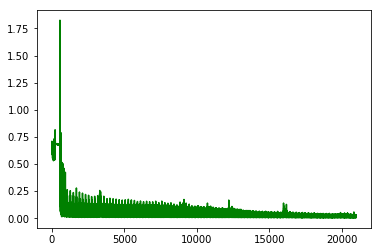

---


In [11]:
#main
model = unet()
model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-4), metrics=['accuracy'])

##可视化一下模型
print(model.summary())

epochs = 100
batch_size = 16
A = []
#model.fit内存不够
for e in range(epochs):
    batches = 0
    for x_batch, y_batch in gen_traindata(train_image_path, train_mask_path, batch_size):
        loss= model.train_on_batch(x_batch, y_batch)
        A.append(abs(float(loss[0])))
        batches += 1
        print("[epoch %d/%d] [batch %d/%d] [loss:%f]" %(e, epochs, batches,210, loss[0]))
model.save(filepath="D:/QLY/SEG/model/model_segment_2020102901.hdf5")



A = np.array(A)
B = np.array(range(len(A)))
draw_loss(B, A, "D:/QLY/SEG/loss/11.png")


test_image_arr = test_prepro(test_path)
test_predict = model.predict(test_image_arr)

saveResult1("D:/QLY/SEG/data-science-bowl-2018/solid/test_predict1", test_predict)
saveResult2("D:/QLY/SEG/data-science-bowl-2018/solid/test_predict2", test_predict)
saveResult3("D:/QLY/SEG/data-science-bowl-2018/solid/test_predict3", test_predict)

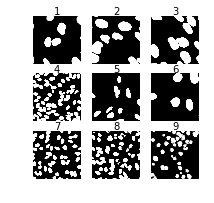

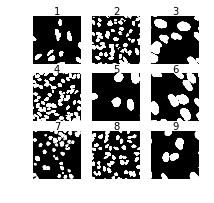

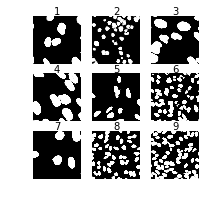

In [12]:
batchDraw("D:/QLY/SEG/data-science-bowl-2018/solid/test_predict1", 9)
batchDraw("D:/QLY/SEG/data-science-bowl-2018/solid/test_predict2", 9)
batchDraw("D:/QLY/SEG/data-science-bowl-2018/solid/test_predict3", 9)